# Project 2: Covid ---> I/ Data selection and matrix construction

The purpose of this file is to select the columns of interest in each data file (original data), make the necessary transformations (e.g. transform 'unknown' into NA, homogenise the units, etc.), and finally create the final data matrix. Then first analyses are performed such as NA or correlation analysis.  
A further selection of features will then be made in the "II_features-selection" file.

In [4]:
# Import
%matplotlib inline

# Used to define paths to files for data import and export
import os
import os.path as op

# Basic libraries 
import math
import numpy as np

# Libraries for plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Used for easier and more structured handling of the data 
import pandas as pd

# Used at the end of this notebook to look more deeply into our data
from pandas_profiling import ProfileReport

# Used to divide the general data into continent-specific data
import pycountry_convert as pc

# Used to handle missing data 
import missingno as msno

%load_ext autoreload
%autoreload 2

We have many dataframe with a category of information for each one:
- DM = Demographics
- DS = Disposition
- ER = Environmental Risk
- HO = Healthcare Encounters
- IE = Inclusion/Exclusion Criteria
- IN = Treatments and Interventions
- LB = Laboratory Results
- MB = Microbiology Specimen
- PO = Pregnancy Outcomes
- RELREC = Related Records
- RP = Reproductive System Findings
- RS = Disease Response and Clinical Classification
- SA = Clinical and Adverse Events
- SC = Subject Characteristics
- SV = Subject Visits
- TI = Trial Inclusion Exclusion Criteria
- TS = Trial Summary
- TV = Trial Visits
- VS = Vital Signs

## 1. Load data

In [7]:
# Load file with descriptions of data variables
data_description_folder = 'data'
data_description = pd.read_csv(op.join(os.getcwd(), data_description_folder, 'IDDO_SDTM_Data-Dictionary_v3.0_2022-10-06.csv') , sep=',', encoding="ISO-8859-1")
data_description.columns = data_description.columns.str.replace(' ', '_')
data_description.head(3)

Domain              Domain_Name Variable_Name             Variable_Label  \
0     AU  Audiometry Test Results       STUDYID           Study Identifier   
1     AU  Audiometry Test Results        DOMAIN        Domain Abbreviation   
2     AU  Audiometry Test Results       USUBJID  Unique Subject Identifier   

  Variable_Type                                Variable_Definition  \
0     character  This variable contains the unique identifier f...   
1     character  This variable contains the two-character abbre...   
2     character  This variable contains the unique subject iden...   

  Controlled_Terminology?  
0                     NaN  
1                       Y  
2                     NaN

## 2. Select data

### For DM:

In [291]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
DM = pd.read_csv(op.join(data_folder, 'DM_2022-09-01.csv'), sep=',', low_memory=False) 
DM.name = 'DM'

In [292]:
# See variables for DM
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==DM.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(DM.columns)]

Variable_Name Variable_Type  \
130       STUDYID     character   
131        DOMAIN     character   
132       USUBJID     character   
134       RFSTDTC     character   
136         DTHFL     character   
138         INVID     character   
140           AGE        number   
141        AGETXT     character   
142          AGEU     character   
143           SEX     character   
144          RACE     character   
145        ETHNIC     character   
146         ARMCD     character   
147           ARM     character   
148       COUNTRY     character   
150          DMDY        number   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Variable_Definition  
130                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
131                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    This variable contains the two-character abbreviation for the domain.  
132                                                                                                                                                                                                                                                                                                                                                              This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
134  This variable describes the date and time of the start of the Subject Reference Period. The Subject Reference Period is defined by IDDO as starting with the subject's first study encounter and ending with the subject's final study encounter. RFSTDTC corresponds with the time and date of the subject's first study encounter (e.g., screening, enrollment, admission). This date will be used to calculate the relative days in the --DY?, --STDY, --ENDY variables.  This date and time will be provided in ISO 8601 format. This variable will be blank for submissions that do not provide this initi

In [293]:
# Investigate SEX
print('Values for SEX: ', DM['SEX'].unique())

Values for SEX:  ['M' 'F' 'U' nan]


In [294]:
# Replace 'U' by NA in SEX
DM['SEX'].replace('U', np.nan, inplace=True)
print('Values for SEX: ', DM['SEX'].unique())

Values for SEX:  ['M' 'F' nan]


In [295]:
# Get value counts for the death indicator variable
nb_yes = DM.DTHFL.value_counts()[0]
tot = len(DM.DTHFL)
nb_nothing = tot-nb_yes

print('Yes for death: ', nb_yes, ' / ', round(nb_yes/tot*100,1), '%')
print('No info for death column: ', nb_nothing, ' / ', round(nb_nothing/tot*100,1), '%')

Yes for death:  170955  /  20.2 %
No info for death column:  673496  /  79.8 %


In [296]:
# Replace NA by N for No in DTHFL
DM.DTHFL.fillna('N', inplace=True)

In fact we will not keep this column because the information on death is provided much more precisely with DS. 

In [297]:
# Combine AGE and AGETXT

print('Values for AGETXT: ', DM['AGETXT'].unique())
print('Min and Max for AGE: ', DM['AGE'].min(), DM['AGE'].max())

DM.loc[DM.AGETXT=='95+', 'AGE'] = 96. # We make the choice to put 96 for 95+

print('Min and Max for AGE after: ', DM['AGE'].min(), DM['AGE'].max())

Values for AGETXT:  [nan '95+']
Min and Max for AGE:  -70.0 94.089996
Min and Max for AGE after:  -70.0 96.0


In [298]:
# Investigate and replace negative values for AGE

print('Values for AGEU: ', DM['AGEU'].unique())
print('Number of negative values for AGE: ', (DM['AGE']<0).sum())
print('Number of NA for AGE: ', DM['AGE'].isna().sum())

DM.loc[DM.AGE<0, 'AGE'] = np.nan # We make the choice to replace negative values by NA

print('Number of NA for AGE after: ', DM['AGE'].isna().sum())

Values for AGEU:  ['YEARS' nan 'MONTHS' 'DAYS']
Number of negative values for AGE:  8
Number of NA for AGE:  22493
Number of NA for AGE after:  22501


In [299]:
# Combine AGE and AGEU

print('Values for AGEU: ', DM['AGEU'].unique())
print('Number of NA for AGEU when AGE is not NA: ', DM.loc[DM.AGE.notna(), 'AGEU'].isna().sum())
print('Min and Max for AGE when AGEU is NA: ', DM.loc[DM.AGEU.isna(), 'AGE'].unique())
print('Min and Max for AGE: ', DM['AGE'].min(), DM['AGE'].max())

# We make the choice to keep the YEARS unit
DM.loc[DM.AGEU=='MONTHS', 'AGE'] /= 12
DM.loc[DM.AGEU=='DAYS', 'AGE'] /= 365

Values for AGEU:  ['YEARS' nan 'MONTHS' 'DAYS']
Number of NA for AGEU when AGE is not NA:  593
Min and Max for AGE when AGEU is NA:  [51. 59. 46. 74. 61. 70. 72. 50. 79. 42. 49. 38. 77. 78. 68. 58. 62. 53.
 56. nan 66. 71. 44. 52. 87. 80. 37. 41. 64. 67. 73. 27. 40. 63. 85. 88.
 91. 92. 60. 45. 76. 86. 83. 47. 57. 69. 54. 65. 55. 81. 29. 48. 43. 89.
 39. 75. 25. 36. 84. 28. 32. 33. 96. 90.  0. 24. 35. 23. 19.  3.  5. 34.
 22. 31. 20.  8. 17. 13.  4.  7. 12. 15. 16. 30. 18. 82.]
Min and Max for AGE:  0.0 96.0


In [300]:
# Investigate ARMCD and ARM
print('Values for ARMCD: ', DM['ARMCD'].unique())
print('Values for ARM: ', DM['ARM'].unique())

Values for ARMCD:  ['PER CLIN GUIDE']
Values for ARM:  ['Per Clinical Guidelines']


In [301]:
print('%NA for DMDY: ', round(DM['DMDY'].isna().sum()/DM.shape[0]*100,1))

%NA for DMDY:  64.5


At first we will keep only country and not race and ethnic because the latter two require much more cleaning.

**=> To conclude, for DM, we can keep: USUBJID, RFSTDT, AGE, SEX and COUNTRY:**

In [302]:
# Keep only some columns for DM
DM = DM[['USUBJID', 'RFSTDTC', 'AGE', 'SEX', 'COUNTRY']]
DM.columns

Index(['USUBJID', 'RFSTDTC', 'AGE', 'SEX', 'COUNTRY'], dtype='object')

In [303]:
DM.shape

(844451, 5)

### For DS:

In [304]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
DS = pd.read_csv(op.join(data_folder, 'DS_2022-09-01.csv'), sep=',', low_memory=False) 
DS.name = 'DS'

In [305]:
# See variables for DS
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==DS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(DS.columns)]

Variable_Name Variable_Type  \
157       STUDYID     character   
158        DOMAIN     character   
159       USUBJID     character   
160         DSSEQ        number   
161        DSTERM     character   
162      DSMODIFY     character   
163       DSDECOD     character   
164      VISITNUM        number   
165         VISIT     character   
166       VISITDY        number   
170          DSDY        number   
171        DSSTDY        number   
175      DSEVINTX     character   
178      DSCDSTDY        number   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
157                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
158                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
159  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
160                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
161                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
162                                                                                                                                                                                                            This variable contains a modification of the verbatim wording of the event. This is used to capture IDDO-defined standardised terms of the event.  
163                                                                                                                                      This variable contains a dictionary-derived text description of the event. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
164                                                                                                                                                                                   This variable contains a number designating the planned clinical encounter number. This is a numeric version of the visit described in VISIT? and it is used for sorting.   
165                                                                                                                                                                                                          This variable contains the protocol-defined text description of the planned cl

In [306]:
# Investigate DSMODIFY
print('Values for DSMODIFY: ', DS['DSMODIFY'].unique())

Values for DSMODIFY:  [nan]


In [307]:
# Investigate DSTERM and DSDECOD
print('Values for DSTERM: ', DS['DSTERM'].unique())
print('Values for DSDECOD: ', DS['DSDECOD'].unique())
# We make the choice to keep only DSDECOD

Values for DSTERM:  ['DISCHARGED ALIVE' 'DEATH' 'TRANSFER TO OTHER FACILITY'
 'MISSING IN DATABASE' 'UNKNOWN' 'HOSPITALIZATION' 'PALLIATIVE DISCHARGE'
 'Death' 'Hospitalisation' 'Discharged alive' 'Transfer to other facility'
 'Medically fit for discharge (COVID-19 resolved) but remains in hospital for other reason'
 'Palliative discharge' 'Unknown'
 'Ongoing health care needs relating to this admission for COVID-19'
 'Ongoing health care needs NOT related to COVID episode'
 'Discharged alive expected to survive' 'DISCHARGED'
 'CURRENTLY HOSPITALISED' 'DISCHARGE' 'TRANSFERRED TO ANOTHER FACILITY'
 'ALIVE' 'DECEASED' 'Forwarding to home'
 'Transfer to another health care facility' 'Hospitalization'
 'Transfer to the Health District' 'Discharge against medical advice'
 'Palliative care' 'QUARANTINE CENTER'
 'TRANSFER TO OTHER HOSPITAL/FACILITY' 'LONG TERM CARE FACILITY'
 'DEATH IN HOSPITAL' 'TRANSFERRED TO ANOTHER UNIT' 'HOSPITAL DISCHARGE'
 'DISCHARGE WITH PALLIATIVE CARE' 'HOSPITALIZED

In [308]:
# Replace UNKNOWN by NA in DSDECOD
DS['DSDECOD'].replace('UNKNOWN', np.nan, inplace=True)
print('Values for DSDECOD: ', DS['DSDECOD'].unique())

Values for DSDECOD:  ['DISCHARGED' 'DEATH' 'TRANSFERRED' nan 'STILL IN HOSPITAL'
 'LOST TO FOLLOW-UP']


In [309]:
# Get value counts for the death indicator variable
DS.DSDECOD.value_counts()

DISCHARGED           608454
DEATH                170551
TRANSFERRED           28089
STILL IN HOSPITAL     12868
LOST TO FOLLOW-UP         3
Name: DSDECOD, dtype: int64

In [310]:
DS.DSDECOD.value_counts(normalize=True)

DISCHARGED           0.742049
DEATH                0.207998
TRANSFERRED          0.034256
STILL IN HOSPITAL    0.015693
LOST TO FOLLOW-UP    0.000004
Name: DSDECOD, dtype: float64

In [311]:
round(DS.DSDECOD.isna().sum()/len(DS.DSDECOD),3)

0.006

In [312]:
# Investigate VISITNUM, VISIT and VISITDY

print('Values for VISITNUM: ', DS['VISITNUM'].unique())
print('Values for VISIT: ', DS['VISIT'].unique())
print('Values for VISITDY: ', DS['VISITDY'].unique())

print('%NA for VISITNUM: ', round(DS['VISITNUM'].isna().sum()/DS.shape[0]*100,2))
print('%NA for VISIT: ', round(DS['VISIT'].isna().sum()/DS.shape[0]*100,2))
print('%NA for VISITDY: ', round(DS['VISITDY'].isna().sum()/DS.shape[0]*100,2))

Values for VISITNUM:  [nan  1.  2.]
Values for VISIT:  [nan 'Day 0' 'Week 2 Day 14']
Values for VISITDY:  [nan  1. 15.]
%NA for VISITNUM:  99.82
%NA for VISIT:  99.82
%NA for VISITDY:  99.82


In [313]:
# Investigate DSDY, DSEVINTX and DSCDSTDY

print('Values for DSDY: ', DS['DSDY'].unique())
print('Values for DSEVINTX: ', DS['DSEVINTX'].unique())
print('Values for DSCDSTDY: ', DS['DSCDSTDY'].unique())

print('%NA for DSDY: ', round(DS['DSDY'].isna().sum()/DS.shape[0]*100,2))
print('%NA for DSEVINTX: ', round(DS['DSEVINTX'].isna().sum()/DS.shape[0]*100,2))
print('%NA for DSCDSTDY: ', round(DS['DSCDSTDY'].isna().sum()/DS.shape[0]*100,2))

Values for DSDY:  [nan 78. 75. 29. 28. 24. 17. 32. 25. 21. 22. 30. 50. 38. 33. 36. 31. 45.
 80. 35. 59. 63. 34. 27. 26. 39. 49. 53. 16. 19. 20. 37. 72. 46. 11. 40.
 23. 48. 42. 54. 14. 90. 41. 51. 13.  7. 12.]
Values for DSEVINTX:  [nan 'AT ANY TIME AFTER DISCHARGE']
Values for DSCDSTDY:  [ nan  16.   2.  20.   8.   5.   4.   1.   9.  14.  25.  51.  18.  19.
  24.  12.  55.   6.  13.  23.  28. 109.   7.  11.  21.   3.]
%NA for DSDY:  99.88
%NA for DSEVINTX:  99.84
%NA for DSCDSTDY:  99.99


**=> To conclude, for DS, we can keep: USUBJID, DSSEQ and DSDECOD:**

In [314]:
# Keep only some columns for DS
DS = DS[['USUBJID', 'DSSEQ', 'DSDECOD']]
DS.columns

Index(['USUBJID', 'DSSEQ', 'DSDECOD'], dtype='object')

In [315]:
DS.shape

(824787, 3)

### For ER:

In [316]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
ER = pd.read_csv(op.join(data_folder, 'ER_2022-09-01.csv'), sep=',', low_memory=False) 
ER.name = 'ER'

In [317]:
# See variables for ER
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==ER.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(ER.columns)]

Variable_Name Variable_Type  \
180       STUDYID     character   
181        DOMAIN     character   
182       USUBJID     character   
183         ERSEQ        number   
184        ERTERM     character   
186         ERCAT     character   
188       ERPRESP     character   
189       EROCCUR     character   
190        ERSTAT     character   
191      ERREASND     character   
192      VISITNUM        number   
193         VISIT     character   
194       VISITDY        number   
199          ERDY        number   
200        ERSTDY        number   
201        ERENDY        number   
206      EREVINTX     character   
207       ERCNTRY     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
180                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
181                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
182  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
183                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
184                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
186                                                                                                                                                                                                                                                                                                  This variable contains a categorization of the observation.  
188                                                                                                                                                                           This variable identifies whether an observation was pre-specified on the CRF. Values are null for spontaneously reported events, i.e. those collected as free-text verbatim terms.  
189                                                                                                                                                                                                                               This variable identifies whether or not a pre-specified event has occurred. Values are null for spontaneously reported events.  
190                                                             This variable contains information about the status of the observation  specif

In [318]:
# Investigate ERCAT
print('Values for ERCAT: ', ER['ERCAT'].unique())

Values for ERCAT:  ['COVID-19 RISK FACTOR']


**=> To conclude, for ER, we can keep nothing because there is no decod of the event, and ECAT is only one value.**

### For HO:

In [319]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
HO = pd.read_csv(op.join(data_folder, 'HO_2022-09-01.csv'), sep=',', low_memory=False) 
HO.name = 'HO'

In [320]:
# See variables for HO
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==HO.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(HO.columns)]

Variable_Name Variable_Type  \
208       STUDYID     character   
209        DOMAIN     character   
210       USUBJID     character   
211         HOSEQ        number   
212       HOREFID     character   
213        HOTERM     character   
214       HODECOD     character   
215         HOCAT     character   
216       HOPRESP     character   
217       HOOCCUR     character   
218        HOSTAT     character   
219      HOREASND     character   
220        HOPATT        number   
221      VISITNUM        number   
222         VISIT     character   
223       VISITDY        number   
227          HODY        number   
228        HOSTDY        number   
229        HOENDY        number   
230         HODUR     character   
233        HOSTRF     character   
234      HOEVINTX     character   
235      HOCDSTDY        number   
236      HODISOUT     character   
237      SELFCARE     character   
238        HOINDC     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
208                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
209                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
210  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
211                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
212                                                                                                           This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
213                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
214                                                                                                                                      This variable contains a dictionary-derived text description of the event. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
215                                                                                                                                                                                                                       

In [321]:
# Investigate HODECOD
print('Values for HODECOD: ', HO['HODECOD'].unique())

Values for HODECOD:  ['HOSPITAL' 'INTENSIVE CARE UNIT']


In [322]:
# NA value for HODY
print('%NA for HODY: ', round(HO['HODY'].isna().sum()/HO.shape[0]*100,2))

%NA for HODY:  65.12


**=> To conclude, for HO, we can keep: USUBJID, HOSEQ and HODECOD:**

In [323]:
# Keep only some columns for HO
HO = HO[['USUBJID', 'HOSEQ', 'HODECOD']]
HO.columns

Index(['USUBJID', 'HOSEQ', 'HODECOD'], dtype='object')

In [324]:
HO.shape

(2336786, 3)

### For IE:

In [325]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
IE = pd.read_csv(op.join(data_folder, 'IE_2022-09-01.csv'), sep=',', low_memory=False)
IE.name = 'IE'

In [326]:
# See variables for IE
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==IE.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(IE.columns)]

Variable_Name Variable_Type  \
239       STUDYID     character   
240        DOMAIN     character   
241       USUBJID     character   
242         IESEQ        number   
243      IETESTCD     character   
244        IETEST     character   
245         IECAT     character   
246       IEORRES     character   
247      IESTRESC     character   
248        IESTAT     character   
249      IEREASND     character   
251          IEDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
239                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
240                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
241                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
242                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
243                                                                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed.   
244                                                                                                                                                                                                                                                                                                                         This variable identifies the name of the test or examination performed.  
245                                                                                                                                                                                                                                                                                                                                     This variable contains a categorization of the observation.  
246                                                                                                                                                                                                    This variable contains the result of the test or examination performed as provided by the data contributor. The original data can be either numericm e.g. "503" or string, e.g., "Positive".  
247  This variable contains the conver

In [327]:
print('Different types of tests :')
for i in range(len(IE['IETEST'].unique())) :
    print(IE['IETEST'].unique()[i])

Different types of tests :
Suspected or confirmed novel coronavirus (COVID-19) infection
Proven infection with pathogen of Public Health Interest
Adult or child who meets Case Definition for Inflammatory Multi-system Syndrome
Proven or high likelihood of infection with pathogen of Public Health Interest
A history of self-reported feverishness or measured fever of >= 38C
Cough
Dyspnoea (shortness of breath) OR Tachypnoea
Clinical suspicion of Acute Respiratory Infection despite not meeting criteria above
Suspected or proven infection with pathogen of Public Health Interest
Suspected or proven acute novel Coronavirus (nCoV) infection as main cause for admission
Patient without Prior Research Authorization (only applicable to Mayo Clinic sites)
Non COVID-19 related admissions
Already included in VIRUS-COVID19 Registry
COVID-19 PCR (any other SARS-CoV-2) test positive (within 21 days)
COVID-19 PCR (any other SARS-CoV-2) test pending
COVID-19 high clinical suspicion
Suspected or proven acut

In [328]:
# Some columns are duplicates, let's look more precisely at them
fever1 = IE[IE['IETEST'] == 'A history of self-reported feverishness or measured fever of >= 38C']
fever2 = IE[IE['IETEST'] == 'A history of self-reported feverishness or measured fever of > 38C']
fever3 = IE[IE['IETEST'] == 'A history of self-reported feverishness or measured fever of  >= 38C']
print(len(fever1), len(fever2), len(fever3))
print(len(fever1.merge(fever2, on = 'USUBJID')))
print(len(fever2.merge(fever3, on = 'USUBJID')))
print(len(fever2.merge(fever3, on = 'USUBJID')))
print(fever3['IESTRESC'].unique())
print("We can see that they don't overlap!")

93937 5689 1072
0
0
0
['Y' 'N']
We can see that they don't overlap!


In [329]:
# Redefinition of the names of some tests 
''' some assumptions and used methods : 
    - "COVID-19 PCR (any other SARS-CoV-2) test positive (within 21 days)" = COVID-positive
    - "COVID-19 currently in the community" = "Contact with confirmed or suspected case"
    - some titles were shortened for better lisibility 
    - uninteresting test names were replaced with nan and removed in the following cell
'''

problematic_tests = ['A history of self-reported feverishness or measured fever of > 38C', 
                     'A history of self-reported feverishness or measured fever of  >= 38C', 
                     'Proven infection with pathogen of Public Health Interest', 
                     'Proven or high likelihood of infection with pathogen of Public Health Interest', 
                     'Proven or suspected infection with pathogen of Public Health Interest',  
                     'Proven or high likelihood of COVID-19',  
                     'COVID-19 high clinical suspicion',
                     'Clinical suspicion of Sars-CoV-2 (COVID-19) infection despite not meeting criteria above',
                     'Dyspnoea (shortness of breath) OR Tachypnoea (respiratory rate  >=50 breaths/min for < 1 year; >=40 breaths/min for 1 - 4 years;>=30 breaths/min for 5 - 12 years;>=20 breaths/min for >=13 years)',
                     'Clinical suspicion of ARI despite not meeting criteria above',
                     'Clinical suspicion of Acute Respiratory Infection despite not meeting criteria above',
                     'COVID-19 PCR (any other SARS-CoV-2) test positive (within 21 days)',
                     'Suspected or proven acute novel Coronavirus (nCoV) infection as main cause for admission',
                     'Patient admitted to intensive care for a non-suspected SARS-Cov2 infection, defined by a hypoxemic respiratory infection without computed tomography images/criteria suggestive of a SARS-Cov2 infection and without microbiological documentation.',
                     'Patient admitted to intensive care for a SARS-Cov2 infection either demonstrated by microbiological documentation or strongly suspected. A demonstrated SARS-Cov2 infection is defined by a respiratory infection caused by coronavirus SARS-Cov2 identified by PCR in a superficial and/or deep respiratory sample (bronchoaspiration, bronchoalveolar lavage or nasopharyngeal swab) with or without computed tomography criteria associated (frosted glass, alveolar condensations). A strongly suspected SARS-Cov2 infection is defined by a hypoxemic respiratory infection associated with CT images (frosted glass, alveolar condensations) suggestive of a SARS-Cov2 respiratory infection without microbiological documentation.',
                     'COVID-19 currently in the community',
                     'Patient who formally opposed to participate to the present study', 
                     'Patient who was previously included in the present study', 
                     'Patient without Prior Research Authorization (only applicable to Mayo Clinic sites)', 
                     'COVID-19 PCR (any other SARS-CoV-2) test pending',
                     'Patient aged 18 years or over', 
                     'Already included in VIRUS-COVID19 Registry'
                    ]

corresponding_labels = ['A history of self-reported feverishness or measured fever of >= 38C', 
                        'A history of self-reported feverishness or measured fever of >= 38C', 
                        'Suspected or proven infection with pathogen of Public Health Interest', 
                        'Suspected or proven infection with pathogen of Public Health Interest',  
                        'Suspected or proven infection with pathogen of Public Health Interest',  
                        'Suspected or confirmed novel coronavirus (COVID-19) infection',
                        'Suspected or confirmed novel coronavirus (COVID-19) infection',
                        'Suspected or confirmed novel coronavirus (COVID-19) infection',
                        'Dyspnoea (shortness of breath) OR Tachypnoea',
                        'Clinical suspicion of Acute Respiratory Infection',
                        'Clinical suspicion of Acute Respiratory Infection',
                        'Suspected or confirmed novel coronavirus (COVID-19) infection', 
                        'Suspected or proven acute novel Coronavirus (COVID-19) infection as main cause for admission', 
                        'Patient admitted to intensive care for a non-suspected SARS-Cov2 infection', 
                        'Patient admitted to intensive care for a SARS-Cov2 infection',
                        'Contact with confirmed or suspected case',
                        np.nan, 
                        np.nan, 
                        np.nan, 
                        np.nan, 
                        np.nan, 
                        np.nan
                       ]
                        
def replaceTestName(string, problems, correct) :
    for i in range(len(problems)) :
        if (string == problems[i]) :
            return correct[i]

In [330]:
# Clean up the relevant test names 
IE['IETEST'] = IE['IETEST'].apply(lambda x : replaceTestName(x, problematic_tests, corresponding_labels) 
                                  if x in problematic_tests else x)
IE.dropna(axis = 0, subset = ['IETEST'], inplace = True)

In [331]:
print('Different types of tests :')
for i in range(len(IE['IETEST'].unique())) :
    print('-', IE['IETEST'].unique()[i])

Different types of tests :
- Suspected or confirmed novel coronavirus (COVID-19) infection
- Suspected or proven infection with pathogen of Public Health Interest
- Adult or child who meets Case Definition for Inflammatory Multi-system Syndrome
- A history of self-reported feverishness or measured fever of >= 38C
- Cough
- Dyspnoea (shortness of breath) OR Tachypnoea
- Clinical suspicion of Acute Respiratory Infection
- Suspected or proven acute novel Coronavirus (COVID-19) infection as main cause for admission
- Non COVID-19 related admissions
- Contact with confirmed or suspected case
- Patient admitted to intensive care for a non-suspected SARS-Cov2 infection
- Patient admitted to intensive care for a SARS-Cov2 infection


In [332]:
# We can still see one thing that we can do : 
# We have to change this so that the information in is one variable and not two
def changeYN(testname, testval) :
    if(testname == 'Non COVID-19 related admissions') :
        if(testval == 'Y') :
            return 'N'
        if(testval == 'N') :
            return 'Y'
    else :
        return testval

IE['IESTRESC'] = IE.apply(lambda x : changeYN(x['IETEST'], x['IESTRESC']), axis = 1)

problematic_test = ['Non COVID-19 related admissions']
corresponding_label = ['Suspected or proven acute novel Coronavirus (COVID-19) infection as main cause for admission']

IE['IETEST'] = IE['IETEST'].apply(lambda x : replaceTestName(x, problematic_test, corresponding_label) 
                                  if x in problematic_test else x)

In [333]:
print('Different types of tests :')
for i in range(len(IE['IETEST'].unique())) :
    print('-', IE['IETEST'].unique()[i])

Different types of tests :
- Suspected or confirmed novel coronavirus (COVID-19) infection
- Suspected or proven infection with pathogen of Public Health Interest
- Adult or child who meets Case Definition for Inflammatory Multi-system Syndrome
- A history of self-reported feverishness or measured fever of >= 38C
- Cough
- Dyspnoea (shortness of breath) OR Tachypnoea
- Clinical suspicion of Acute Respiratory Infection
- Suspected or proven acute novel Coronavirus (COVID-19) infection as main cause for admission
- Contact with confirmed or suspected case
- Patient admitted to intensive care for a non-suspected SARS-Cov2 infection
- Patient admitted to intensive care for a SARS-Cov2 infection


**=> To conclude, for IE, we can keep USUBJID, IETEST, IESEQ and IESTRESC.**

In [334]:
# Keep only some columns for IN
IE = IE[["USUBJID", "IETEST", "IESTRESC", "IESEQ"]]
IE.columns

Index(['USUBJID', 'IETEST', 'IESTRESC', 'IESEQ'], dtype='object')

In [335]:
IE.shape

(944978, 4)

### For IN:

In [336]:
# Import data, done by chunks as the file is huge 
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
mylist = []
for chunk in pd.read_csv(op.join(data_folder, 'IN_2022-09-01.csv'), sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
IN = pd.concat(mylist, axis=0)
IN.name = 'IN'
del mylist

In [337]:
# See variables for IN
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==IN.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(IN.columns)]

Variable_Name Variable_Type  \
252       STUDYID     character   
253        DOMAIN     character   
254       USUBJID     character   
255       SPDEVID     character   
256         INSEQ        number   
257       INREFID     character   
259         INTRT     character   
260      INMODIFY     character   
261       INDECOD     character   
262         INCAT     character   
263        INSCAT     character   
264       INPRESP     character   
265       INOCCUR     character   
266        INSTAT     character   
267      INREASND     character   
268        ININDC     character   
269        INCLAS     character   
270      INCLASCD     character   
271        INDOSE        number   
272      INDOSTXT     character   
273        INDOSU     character   
274      INDOSFRM     character   
275      INDOSFRQ     character   
276      INDOSTOT        number   
277       INROUTE     character   
278      INDOSRGM     character   
286      VISITNUM        number   
287         VISIT     character   
288       VISITDY        number   
293          INDY        number   
294        INSTDY        number   
295        INENDY        number   
296         INDUR     character   
302        INSTRF     character   
304      INEVLINT     character   
305      INEVINTX     character   
310      INCDSTDY        number   

                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
252                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
253                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
254     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
255                                                                                     This variable contains the short code for the device in use. This code will be the same as in the DI domain under the same variable name (SPDEVID). This functions as a key to link the descriptions of the device found in the DI domain with the usage in the IN domain.   
256                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
257                                                                                                              This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
259                                                                                                                                                                    

In [338]:
# Investigate INMODIFY
print('Values for INMODIFY: ', IN['INMODIFY'].unique())

Values for INMODIFY:  ['INVASIVE VENTILATION' 'VENTILATED' 'HYDROXYCHLOROQUINE' 'OXYGEN THERAPY'
 'NEURAMINIDASE INHIBITORS' 'HIGH-FLOW NASAL CANNULA' 'STEROIDS'
 'CHEMOTHERAPY' 'COLCHICINE' 'ECMO' 'LOPINAVIR' 'INTERFERON BETA'
 'PRONE VENTILATION' 'CPR' 'ANTIINFLAMMATORY' 'IMMUNOSUPPRESSANTS'
 'HYDROCORTISONE' 'DIALYSIS/RENAL TREATMENT' 'REMDESIVIR' 'AZITHROMYCIN'
 'ANTIRETROVIRAL' 'OTHER INTERVENTION OR PROCEDURE' 'ANTIBIOTIC AGENTS'
 'THERAPEUTIC ANTICOAGULANT' 'CHLOROQUINE' 'MECHANICAL SUPPORT'
 'ANTIFUNGAL AGENTS' 'SARILUMAB' 'TOCILIZUMAB' 'INTERFERON ALPHA'
 'DEXAMETHASONE' 'CARDIOVASCULAR SUPPORT' 'COVID-19 VACCINATION'
 'INOTROPES' 'PACING' 'RIBAVIRIN' 'ANTIVIRAL AGENTS'
 'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM' 'RESPIRATORY SUPPORT'
 'NON-INVASIVE VENTILATION' 'IMMUNOGLOBULINS'
 'COVID-19 VACCINE PFIZER-BIONTECH'
 'COVID-19 VACCINE JANSSENS (JOHNSON AND JOHNSON)'
 'AMOXICILLIN AND BETA-LACTAMASE INHIBITOR'
 'COVID-19 VACCINE TYPE UNKNOWN' nan 'ZINC' 'CEFTRIAXONE'
 'ASCO

In [339]:
# Investigate INMODIFY
print('NA values for INMODIFY: ', round(IN['INMODIFY'].isna().sum()/IN.shape[0],2))

NA values for INMODIFY:  0.02


In [340]:
# Investigate INCLAS
print('Values for INCLAS: ', IN['INCLAS'].unique())

Values for INCLAS:  ['ARTIFICIAL RESPIRATION' 'ANTIMALARIALS' 'OXYGEN'
 'ANTIVIRALS FOR SYSTEMIC USE' 'HIGH FLOW OXYGEN NASAL CANNULA'
 'CORTICOSTEROIDS FOR SYSTEMIC USE' 'CHEMOTHERAPY'
 'ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODUCTS, NON-STEROIDS'
 'EXTRACORPOREAL MEMBRANE OXYGENATION' 'IMMUNOSTIMULANTS'
 'PRONE BODY POSITION' 'CARDIOPULMONARY RESUSCITATION'
 'IMMUNOSUPPRESSANTS' 'RENAL REPLACEMENT'
 'ANTIBACTERIALS FOR SYSTEMIC USE' nan 'ANTITHROMBOTIC AGENTS'
 'ANTIMYCOTICS FOR SYSTEMIC USE' 'CARDIAC THERAPY' 'VACCINES'
 'CARDIAC PACING' 'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM'
 'NONINVASIVE VENTILATION' 'IMMUNOGLOBULINS' 'ANALGESICS'
 'TRANSFUSION OF BLOOD PRODUCT' 'LIPID MODIFYING AGENTS'
 'DRUGS FOR ACID RELATED DISORDERS' 'MUSCLE RELAXANTS'
 'OTHER RESPIRATORY SYSTEM PRODUCTS' 'INSERTION OF TRACHEOSTOMY TUBE'
 'DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES' 'PSYCHOLEPTICS' 'DIURETICS'
 'BETA BLOCKING AGENTS' 'ANESTHETICS'
 'BLOOD SUBSTITUTES AND PERFUSION SOLUTIONS' 'BRONCHOSCOPY'


In [341]:
# Investigate INCLAS
print('Values for INCLAS:\n', IN['INCLAS'].value_counts(normalize=True, dropna=False))

Values for INCLAS:
 ANTIVIRALS FOR SYSTEMIC USE                                  0.099480
ARTIFICIAL RESPIRATION                                       0.091678
CORTICOSTEROIDS FOR SYSTEMIC USE                             0.083986
IMMUNOSUPPRESSANTS                                           0.068704
OXYGEN                                                       0.062425
ANTIBACTERIALS FOR SYSTEMIC USE                              0.059972
NaN                                                          0.048714
HIGH FLOW OXYGEN NASAL CANNULA                               0.044329
ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODUCTS, NON-STEROIDS    0.040269
CARDIAC THERAPY                                              0.038568
PRONE BODY POSITION                                          0.035545
NONINVASIVE VENTILATION                                      0.035530
EXTRACORPOREAL MEMBRANE OXYGENATION                          0.035166
ANTIMYCOTICS FOR SYSTEMIC USE                                0.030266


In [342]:
# Count NA for INDY
print('%NA for INDY: ', round(IN['INDY'].isna().sum()/IN.shape[0]*100,1))

%NA for INDY:  66.2


**=> To conclude, for IN, we can keep: USUBJID, INSEQ and INCLAS:**

In [343]:
# Keep only some columns for IN
IN.drop(columns =['STUDYID', 'DOMAIN', 'SPDEVID', 'INREFID', 'INTRT',
       'INMODIFY', 'INDECOD', 'INCAT', 'INSCAT', 'INPRESP', 'INOCCUR',
       'INSTAT', 'INREASND', 'ININDC', 'INCLASCD', 'INDOSE',
       'INDOSTXT', 'INDOSU', 'INDOSFRM', 'INDOSFRQ', 'INDOSTOT', 'INDOSRGM',
       'INROUTE', 'VISITNUM', 'VISIT', 'VISITDY', 'INDY', 'INSTDY', 'INENDY',
       'INDUR', 'INSTRF', 'INEVLINT', 'INEVINTX', 'INCDSTDY'], inplace=True)
IN.columns

Index(['USUBJID', 'INSEQ', 'INCLAS'], dtype='object')

In [344]:
IN.shape

(43338429, 3)

### For LB:

In [345]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
LB = pd.read_csv(op.join(data_folder, 'LB_2022-09-01.csv'), sep=',', low_memory=False)
LB.name = 'LB'

In [346]:
# See variables for LB
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==LB.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(LB.columns)]

Variable_Name Variable_Type  \
317       STUDYID     character   
318        DOMAIN     character   
319       USUBJID     character   
320         LBSEQ        number   
322      LBTESTCD     character   
323        LBTEST     character   
324         LBCAT     character   
325        LBSCAT     character   
326       LBORRES     character   
327      LBORRESU     character   
330      LBSTRESC     character   
331      LBSTRESN        number   
332      LBSTRESU     character   
333        LBSTAT     character   
334      LBREASND     character   
336        LBSPEC     character   
338      LBMETHOD     character   
339      VISITNUM        number   
340         VISIT     character   
341       VISITDY        number   
345          LBDY        number   
350        LBSTRF     character   
351      LBEVINTX     character   
354      LBCDSTDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
317                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
318                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
319                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
320                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
322                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
323                                                                                                                                                                                                                                                                        This variable identifies the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
324                                                                                                                                                                                                                                                                                                                                     This variable contains a categorization of the observation.  
325     

In [347]:
# Investigate LBTESTCD
print('Values for LBTESTCD: ', LB['LBTESTCD'].unique())

Values for LBTESTCD:  ['HCT' 'PLAT' 'HGB' 'WBC' 'AST' 'BILI' 'CREAT' 'LYM' 'INR' 'PCO2' 'NEUT'
 'PT' 'UREAN' 'CRP' 'ALT' 'GLUC' 'PH' 'SODIUM' 'BICARB' 'PO2' 'K' 'CK'
 'TROPONI' 'LDH' 'FERRITIN' 'PCT' 'DDIMER' 'LACTICAC' 'NEUTLE' 'LYMLE'
 'BASEEXCS' 'INTLK6' 'APTT' 'APTTSTND' 'HBA1C' 'ESR' 'OXYSAT' 'ALB'
 'TROPONIN' 'MCH' 'RBC' 'RDW' 'IRON' 'MONO' 'EOS' 'EOSLE' 'BASOLE'
 'MONOLE' 'MCHC' 'MCV' 'PROT' 'CL' 'AMYLASE' 'MPV' 'PLATHCT' 'BASO' 'CHOL'
 'URATE' 'PTAC' 'FIBRINO' 'BILDIR' 'CA' 'GGT' 'TT' 'MG' 'CAION' 'CAIONPH'
 'CARBXHGB' 'HGBDOXY' 'HGBMET' 'HGBOXY' 'CO2' 'TROPONT' 'PO2FIO2'
 'FIBRINOF' 'UREA' 'ALP' 'CD4' 'NEUTSG' 'AUERRODS']


In [348]:
# Check units
for t in LB['LBTESTCD'].unique():
    print(t, ' ---> ', LB.LBSTRESU[LB.LBTESTCD == t].unique())

HCT  --->  ['%' nan]
PLAT  --->  ['10^9/L' nan]
HGB  --->  ['g/L' nan]
WBC  --->  ['10^9/L' nan]
AST  --->  ['U/L' nan]
BILI  --->  ['umol/L' nan]
CREAT  --->  ['umol/L' nan]
LYM  --->  ['10^9/L' nan]
INR  --->  ['RATIO' nan]
PCO2  --->  [nan]
NEUT  --->  ['10^9/L' nan]
PT  --->  ['sec' nan]
UREAN  --->  ['mmol/L' nan]
CRP  --->  ['mg/L' nan]
ALT  --->  ['U/L' nan]
GLUC  --->  ['mmol/L' nan]
PH  --->  [nan]
SODIUM  --->  ['mmol/L' nan]
BICARB  --->  ['mEq/L' nan]
PO2  --->  [nan]
K  --->  ['mmol/L' nan]
CK  --->  ['U/L' nan]
TROPONI  --->  ['ug/L' nan]
LDH  --->  ['U/L' nan]
FERRITIN  --->  ['ug/L' nan]
PCT  --->  ['ug/L' nan]
DDIMER  --->  [nan 'mg/L']
LACTICAC  --->  ['mmol/L' nan]
NEUTLE  --->  ['%']
LYMLE  --->  ['%']
BASEEXCS  --->  ['mmol/L' nan]
INTLK6  --->  ['ng/L' nan]
APTT  --->  ['sec' nan]
APTTSTND  --->  ['RATIO' nan]
HBA1C  --->  [nan]
ESR  --->  [nan 'mm/h']
OXYSAT  --->  [nan]
ALB  --->  [nan]
TROPONIN  --->  [nan]
MCH  --->  [nan]
RBC  --->  [nan]
RDW  --->  [nan]
IRO

There is only one unit for each test so we do not need to uniformize them.

In [349]:
# NA for LBDY
print('%NA for LB: ', round(LB['LBDY'].isna().sum()/LB.shape[0]*100,2))

%NA for LB:  2.01


**=> To conclude, for LB, we can keep: USUBJID, LBSEQ, LBTESTCD, LBSTRESC, LBSTRESU and LBDY:**

In [350]:
# Keep only some columns for LB
LB = LB[['USUBJID', 'LBSEQ', 'LBTESTCD', 'LBSTRESC', 'LBSTRESU', 'LBDY']]
LB.columns

Index(['USUBJID', 'LBSEQ', 'LBTESTCD', 'LBSTRESC', 'LBSTRESU', 'LBDY'], dtype='object')

In [351]:
LB.shape

(7330863, 6)

### For MB:

In [352]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
MB = pd.read_csv(op.join(data_folder, 'MB_2022-09-01.csv'), sep=',', low_memory=False)
MB.name = 'MB'

In [353]:
# See variables for MB
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==MB.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(MB.columns)]

Variable_Name Variable_Type  \
356       STUDYID     character   
357        DOMAIN     character   
358       USUBJID     character   
359         MBSEQ        number   
362      MBTESTCD     character   
363        MBTEST     character   
365      MBTSTDTL     character   
366         MBCAT     character   
367        MBSCAT     character   
368       MBORRES     character   
369      MBORRESU     character   
370      MBSTRESC     character   
371      MBSTRESN        number   
372      MBSTRESU     character   
373        MBSTAT     character   
374      MBREASND     character   
375        MBSPEC     character   
377         MBLOC     character   
378      MBMETHOD     character   
379      VISITNUM        number   
380         VISIT     character   
381       VISITDY        number   
384          MBDY        number   
389        MBSTRF     character   
390      MBEVINTX     character   
393      MBCDSTDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
356                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
357                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
358                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
359                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
362                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
363                                                                                                                                                                                                                                                                        This variable identifies the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
365                                                                                                                                                                                                                                                                                                                                     

In [354]:
# Investigate MBCAT
print('Values for MBCAT: ', MB['MBCAT'].unique())

Values for MBCAT:  ['BACTERIA' 'RSV' 'CORONAVIRUS' 'ADENOVIRUS' 'OTHER RESPIRATORY PATHOGENS'
 'INFLUENZA' nan 'OTHER PATHOGENS' 'FUNGUS']


In [355]:
# Investigate MBTSTDTL
print('Values for MBTSTDTL: ', MB['MBTSTDTL'].unique())

Values for MBTSTDTL:  ['DETECTION' 'IDENTIFICATION' 'VARIANT TYPE']


In [356]:
# Replace UNKNOWN by NA in MBSTRESC
MB.replace('UNKNOWN', np.nan, inplace=True)

In [357]:
# Replace NOT SURE by NA in MBSTRESC
MB.replace('NOT SURE', np.nan, inplace=True)

In [358]:
# Investigate MBSTRESC
print('Values for MBSTRESC for detection:\n', MB.loc[MB.MBTSTDTL=='DETECTION', 'MBSTRESC'].value_counts(normalize=True, dropna=False))

Values for MBSTRESC for detection:
 POSITIVE    0.477894
NaN         0.277023
NEGATIVE    0.245084
Name: MBSTRESC, dtype: float64


In [359]:
# Investigate MBSTRESC
print('Values for MBSTRESC for identification:\n', MB.loc[MB.MBTSTDTL=='IDENTIFICATION', 'MBSTRESC'].value_counts(normalize=True, dropna=False))

Values for MBSTRESC for identification:
 SEVERE ACUTE RESPIRATORY SYNDROME CORONAVIRUS 2    0.819583
NaN                                                0.068448
ESCHERICHIA COLI                                   0.009928
METHICILLIN RESISTANT STAPHYLOCOCCUS AUREUS        0.009609
STAPHYLOCOCCUS AUREUS                              0.006104
                                                     ...   
ROTHIA DENTOCARIOSA                                0.000008
CAMPYLOBACTER COLI                                 0.000008
MEASLES MORBILLIVIRUS                              0.000008
PSYCHROBACTER PHENYLPYRUVICUS                      0.000008
PLASMODIUM                                         0.000008
Name: MBSTRESC, Length: 338, dtype: float64


In [360]:
# Investigate MBSTRESC
print('Values for MBSTRESC for variant type:\n', MB.loc[MB.MBTSTDTL=='VARIANT TYPE', 'MBSTRESC'].value_counts(normalize=True, dropna=False))

Values for MBSTRESC for variant type:
 NaN                    0.565113
OMICRON - B.1.1.529    0.282316
DELTA - B.1.617.2      0.096348
BETA - B.1.351         0.040005
OMICRON                0.011413
ALPHA - B.1.1.7        0.004565
THETA- P.3             0.000120
KAPPA - B.1.617.1      0.000120
Name: MBSTRESC, dtype: float64


In [361]:
# Investigate MBCAT
print('Values for MBCAT for not detection: ', MB.loc[MB.MBTSTDTL!='DETECTION', 'MBCAT'].unique())

Values for MBCAT for not detection:  ['CORONAVIRUS' 'INFLUENZA' 'OTHER RESPIRATORY PATHOGENS' 'BACTERIA' nan
 'OTHER PATHOGENS' 'FUNGUS']


In [362]:
# Investigate MBCAT
print('Values for MBCAT:\n', MB['MBCAT'].value_counts(normalize=True, dropna=False))

Values for MBCAT:
 NaN                            0.484957
CORONAVIRUS                    0.262590
INFLUENZA                      0.233954
BACTERIA                       0.006199
OTHER RESPIRATORY PATHOGENS    0.005948
RSV                            0.002731
ADENOVIRUS                     0.002433
OTHER PATHOGENS                0.001122
FUNGUS                         0.000067
Name: MBCAT, dtype: float64


In [363]:
# NA value for MBDY
print('%NA for MBDY: ', round(MB['MBDY'].isna().sum()/MB.shape[0]*100,2))

%NA for MBDY:  99.16


**=> To conclude, for MB, we can keep:**
- **list of USUBJID for patients that are 'SEVERE ACUTE RESPIRATORY SYNDROME CORONAVIRUS 2' in MBSTRESC**
- **USUBJID, MBSEQ, MBCAT only for detection and MBSTRESC**

In [364]:
# list of USUBJID for patients that are 'SEVERE ACUTE RESPIRATORY SYNDROME CORONAVIRUS 2' in MBSTRESC
IDlist_severeCovid_MBSTRESC = MB.loc[MB.MBSTRESC=='SEVERE ACUTE RESPIRATORY SYNDROME CORONAVIRUS 2', 'USUBJID'].tolist()

In [365]:
# Keep only some columns for MB
MB = MB.loc[MB.MBTSTDTL=='DETECTION', ['USUBJID', 'MBSEQ', 'MBCAT', 'MBSTRESC']]
MB.columns

Index(['USUBJID', 'MBSEQ', 'MBCAT', 'MBSTRESC'], dtype='object')

In [366]:
MB.shape

(1980903, 4)

### For PO:

In [11]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
PO = pd.read_csv(op.join(data_folder, 'PO_2022-09-01.csv'), sep=',', low_memory=False)
PO.name = 'PO'

In [12]:
# See variables for PO
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==PO.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(PO.columns)]

Variable_Name Variable_Type  \
519       STUDYID     character   
520        DOMAIN     character   
521       USUBJID     character   
522         POSEQ        number   
523        POTERM     character   
525         POCAT     character   
530      VISITNUM        number   
531         VISIT     character   
532       VISITDY        number   
537          PODY        number   
538        POSTDY        number   
539        POENDY        number   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
519                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
520                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
521  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
522                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
523                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
525                                                                                                                                                                                                                                                                                                  This variable contains a categorization of the observation.  
530                                                                                                                                                                                   This variable contains a number designating the planned clinical encounter number. This is a numeric version of the visit described in VISIT? and it is used for sorting.   
531                                                                                                                                                                                                          This variable contains the protocol-defined text description of the planned clinical encounter number (as defined in the Trial Visits (TV) Domain).  
532                                                                                                                                                                    This variable contains a number designating the Study Day of the planned clinical encounter. This is also a numeric version of the visit described in VISIT? and can be used for sorting. 

In [13]:
# Investigate POTERM
print('Values for variable POTERM: ', PO['POTERM'].unique())

Values for variable POTERM:  ['Live Birth' 'Pregnancy' 'UNKNOWN' 'Stillbirth' 'Born Alive']


The only important thing is that the person is pregnant, as the outcome of the delivery is always the same. However, this information is already in the RP table so nothing will be kept from PO.

**=> To conclude, for PO, we can keep nothing.**

### For RELREC:

In [8]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
RELREC = pd.read_csv(op.join(data_folder, 'RELREC_2022-09-01.csv'), sep=',', low_memory=False)
RELREC.name = 'RELREC'

In [9]:
# See variables for RELREC
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==RELREC.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(RELREC.columns)]

Variable_Name Variable_Type  \
600       STUDYID     character   
601       USUBJID     character   
602       RSUBJID     character   
603        RELREC     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
600                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
601  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
602                                                                                                                                                                                                                                                                 This variable contains the related unique subject identifier from the same or another study.  
603                                                                                                                                                                    This variable contains the patient relationship type between the identifier contained in USUBJID and the identifier contained in RSUBJID. This is defined by IDDO Controlled Terminology.

In [10]:
# Investigate RELREC
print('Values for variable "RELREC": ', RELREC['RELREC'].unique())

Values for variable "RELREC":  ['SAME']


**=> To conclude, for RELREC, we can keep nothing.**

### For RP:

In [373]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
RP = pd.read_csv(op.join(data_folder, 'RP_2022-09-01.csv'), sep=',', low_memory=False)
RP.name = 'RP'

In [374]:
# See variables for RP
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==RP.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(RP.columns)]

Variable_Name Variable_Type  \
604       STUDYID     character   
605        DOMAIN     character   
606       USUBJID     character   
607         RPSEQ        number   
608      RPTESTCD     character   
609        RPTEST     character   
612       RPORRES     character   
613      RPORRESU     character   
614      RPSTRESC     character   
615      RPSTRESN        number   
616      RPSTRESU     character   
617        RPSTAT     character   
618      RPREASND     character   
620      VISITNUM        number   
621         VISIT     character   
622       VISITDY        number   
625          RPDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
604                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
605                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
606                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
607                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
608                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
609                                                                                                                                                                                                                                                                        This variable identifies the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
612                                                                                                                                                                                                    This variable contains the result of the test or examination performed as provided by the data contributor. The original data can be either numericm e.g. "503" or string, e.g., "Positive".  
613                                                                                                                                                                                                                       This variable contains the unit for

In [375]:
# Investigate RPTESTCD
print('Values for RPTESTCD: ', RP['RPTESTCD'].unique())

Values for RPTESTCD:  ['PREGIND' 'EGESTAGE']


In [376]:
# Investigate RPSTRESC
print('Values for RPSTRESC: ', RP['RPSTRESC'].unique())

Values for RPSTRESC:  [nan 'N' '27' 'Y' 'U' '40' '36' '25' '30' '39' '37' '22' '31' '20' '24'
 '26' '3' '28' '32' '12' '38' '33' '23' '9' '8' '13' '29' '18' '41' '35'
 '34.00' '37.00' '38.00' '33.00' '40.00' '7.00' '41.00' '28.00' '32.00'
 '00.06' '25.00' '38.01' '40.02' '40.04' '40.01' '37.02' '34.06' '39.00'
 '8.00' '41.60' '35.00' '39.04' '30.00' '36.00' '27.00' '20.05' '35.50'
 '40.20' '27.03' '12.00' '37.10' '36.10' '39.20' '39.50' '38.50' '38.80'
 '38.60' '6.00' '20.00' '9.00' '29.00' '22.00' '38.10' '33.60' '18.00'
 '35.40' '22.20' '31.00' '37.60' '38.40' '40.30' '29.60' '0.39' '34.85'
 '37.85' '41.15' '21.85' '37.30' '24.00' '41.57' '34.60' '39.03' '39.30'
 '23.09' '28.20' '37.35' '38.15' '33.70' '33.40' '26.00' '38.30' '40.50'
 '04.00' '11.00' '24.01' '36.06' '10.00' '19.00' '22.02' '36.50' '23.00'
 '06.00' '0.40' '0.46' '39.10' '32.40' '34.10' '15.00' '09.00' '34.01'
 '38.75' '37.06' '41.06' '41.05' '36.04' '39.06' '39.05' '42.00' '41.01'
 '33.06' '41.03' '17.03' '38.02' '36.

The information that the person is pregnant will be kept but no more => The numbers can be replaced by a Yes 'Y' because the person is indeed pregnant. U 'unknown' can be replaced by NA.  The number of observations indicators can be removed as it just keeps the fact that the person is pregnant or not:

In [377]:
def containsNumber(value):
    if True in [char.isdigit() for char in value]:
        return True
    return False

def replace(elm):
    if isinstance(elm, str) and containsNumber(elm):
        return 'Y'
    elif elm == 'U':
        return np.nan
    else:
        return elm

RP['RPSTRESC'] = RP['RPSTRESC'].apply(replace)

print('Values for RPSTRESC: ', RP['RPSTRESC'].unique())

Values for RPSTRESC:  [nan 'N' 'Y']


In [378]:
# NA for RPDY
print('%NA for RP: ', round(RP['RPDY'].isna().sum()/RP.shape[0]*100,2))

%NA for RP:  82.2


**=> To conclude, for RP, we can keep: USUBJID and RPSTRESC:**

In [379]:
# Keep only some columns for RP
RP = RP[['USUBJID', 'RPSTRESC']]
RP.columns

Index(['USUBJID', 'RPSTRESC'], dtype='object')

In [380]:
# See how many lines are dropped when dropping duplicates
RP.shape

(331326, 2)

In [381]:
RP.drop_duplicates(inplace=True)

In [382]:
RP.shape

(325315, 2)

### For RS:

In [383]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
RS = pd.read_csv(op.join(data_folder, 'RS_2022-09-01.csv'), sep=',', low_memory=False)
RS.name = 'RS'

In [384]:
# See variables for RS
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==RS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(RS.columns)]

Variable_Name Variable_Type  \
634       STUDYID     character   
635        DOMAIN     character   
636       USUBJID     character   
637         RSSEQ        number   
638      RSTESTCD     character   
639        RSTEST     character   
640         RSCAT     character   
641        RSSCAT     character   
642       RSORRES     character   
643      RSORRESU     character   
644      RSSTRESC     character   
645      RSSTRESN        number   
646      RSSTRESU     character   
647        RSSTAT     character   
648      RSREASND     character   
654          RSDY        number   
659      RSEVINTX     character   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
634                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
635                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
636                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
637                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
638                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
639                                                                                                                                                                                                                                                                        This variable identifies the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
640                                                                                                                                                                                                                                                                                                                                     This variable contains a categorization of the observation.  
641                                                                                                                                                                                                                                                          

In [385]:
# Investigate RSCAT
print('Values for RSCAT: ', RS['RSCAT'].unique())

Values for RSCAT:  ['GCS NINDS VERSION' 'AVPU' 'RASS' 'SAS' 'ICU MOBILITY SCALE'
 'CLINICAL FRAILTY SCORE' 'PRISM III' 'BLANTYRE COMA SCALE' 'SOFA'
 'SAPS II']


In [386]:
# Investigate RSSTRESC
print('Values for RSSTRESC: ', RS['RSSTRESC'].unique())

Values for RSSTRESC:  ['15' 'VERBAL' 'ALERT' '0' 'PAINFUL' '6' '-4' 'UNRESPONSIVE' '8' '-3' '13'
 '-5' '-1' '3' '11' '-2' '14' '4' '5' '9' '7' '10' '1' '2' '12' '24' nan
 '03' '06' '07' '08' '05' '04' '16' '02' '09' '01' '00' '84' '3.5' '9.3'
 '3.1' '23' '50' '0.3' '14.5' '015' '014' '6.0' '95' '170' '90' '4.5'
 '6.4' '45' '30' '180' '3.0' ' -4' '18' '1.5' '0.8' '1412' '125.3' '20'
 '19' '0.4' '3.6' '4.7' '7.4' '0.6' '94' ' -3' '365' 'NOT APPLICABLE'
 '145' '151' 'CONFUSED' '1.6' '+1' '+2' '+4' '1500' '-5.9' '-0.4' '-23'
 '2.5' '+3' '8.0' '.4' '+5' '9.7' '316' '-0.3' '-3.2' '-6' '-56' '7.5'
 'NT' '932' '-0' '-4.8' '-2139' 'SEDATED' '-1+1' 'CONFUSION']


In [387]:
# NA for RSDY
print('%NA for RSDY: ', round(RS['RSDY'].isna().sum()/RS.shape[0]*100,2))

%NA for RSDY:  0.15


**=> To conclude, for RS, we can keep: USUBJID, RSSEQ, RSCAT, RSSTRESC and RSDY:**

In [388]:
# Keep only some columns for RS
RS = RS[['USUBJID', 'RSSEQ', 'RSCAT', 'RSSTRESC', 'RSDY']]
RS.columns

Index(['USUBJID', 'RSSEQ', 'RSCAT', 'RSSTRESC', 'RSDY'], dtype='object')

In [389]:
RS.shape

(996204, 5)

### For SA:

In [390]:
# Import data, done in chunks as data file is huge 
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
mylist = []
for chunk in pd.read_csv(op.join(data_folder, 'SA_2022-09-01.csv'), sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
SA = pd.concat(mylist, axis=0)
SA.name = 'SA'
del mylist

In [391]:
# See variables for SA
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==SA.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(SA.columns)]

Variable_Name Variable_Type  \
664       STUDYID     character   
665        DOMAIN     character   
666       USUBJID     character   
667         SASEQ        number   
668       SAREFID     character   
670      SAMODIFY     character   
679         SACAT     character   
680        SASCAT     character   
681       SAPRESP     character   
682       SAOCCUR     character   
683        SASTAT     character   
684      SAREASND     character   
690         SASEV     character   
707      VISITNUM        number   
708         VISIT     character   
709       VISITDY        number   
714          SADY        number   
715        SASTDY        number   
716        SAENDY        number   
717         SADUR     character   
721        SASTRF     character   
723      SAEVLINT     character   
724      SAEVINTX     character   
729      SACDSTDY        number   
730        SARPOC     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
664                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
665                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
666  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
667                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
668                                                                                                           This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
670                                                                                                                                                                                                            This variable contains a modification of the verbatim wording of the event. This is used to capture IDDO-defined standardised terms of the event.  
679                                                                                                                                                                                                                                                                                                  This variable contains a categorization of the observation.  
680                                                                                                                                                                                                                                                          

In [392]:
# Investigate SAMODIFY
print('Values for SAMODIFY: ', SA['SAMODIFY'].unique())

Values for SAMODIFY:  ['ANOREXIA' 'SHORTNESS OF BREATH' 'FATIGUE/MALAISE'
 'CHRONIC NEUROLOGICAL DISORDER' nan 'COUGH - WITH HAEMOPTYSIS'
 'CHEST PAIN' 'CHRONIC KIDNEY DISEASE' 'CONJUNCTIVITIS' 'HYPERTENSION'
 'ASTHMA' 'DIARRHOEA' 'COUGH' 'COUGH - PRODUCTIVE' 'SMOKING' 'HEADACHE'
 'LYMPHADENOPATHY' 'TUBERCULOSIS' 'INABILITY TO WALK'
 'MUSCLE ACHES/JOINT PAIN' 'RHEUMATOLOGICAL DISORDER'
 'CHRONIC PULMONARY DISEASE (NOT ASTHMA)' 'SKIN RASH'
 'CHRONIC HAEMATOLOGICAL DISEASE' 'LOST/ALTERED SENSE OF TASTE'
 'DIABETES MELLITUS - TYPE 2' 'RUNNY NOSE' 'MALIGNANT NEOPLASM'
 'CHRONIC CARDIAC DISEASE (NOT HYPERTENSION)' 'SORE THROAT' 'OBESITY'
 'ABDOMINAL PAIN' 'SEIZURES' 'DIABETES MELLITUS - TYPE NOT SPECIFIED'
 'ALTERED CONSCIOUSNESS/CONFUSION' 'LOST/ALTERED SENSE OF SMELL'
 'MODERATE OR SEVERE LIVER DISEASE' 'FEVER/HISTORY OF FEVER'
 'MALNUTRITION' 'COVID-19 SYMPTOMS' 'ASPLENIA' 'HIV' 'VOMITING/NAUSEA'
 'OTHER' 'WHEEZING' 'DEMENTIA' 'MILD LIVER DISEASE'
 'DIABETES MELLITUS - TYPE 1' 'BLEEDING'

"For COVID diagnosis, the MB domain contains all testin done for each patient. In some cases a clinical diagnosis may have ben made in addition or instead of testing and this can be found in the SA domain where SAMODIFY='CLINICALLY-DIAGNOSED COVID-19'." => **We will therefore keep the USUBJID for patients who are marked 'CLINICALLY-DIAGNOSED COVID-19' in SAMODIFY to add the information to that contained in MB.**

In [393]:
# List of USUBJID for patients who are marked CLINICALLY-DIAGNOSED COVID-19 in SAMODIFY
IDlist_SAMODIFY = SA.loc[SA.SAMODIFY=='CLINICALLY-DIAGNOSED COVID-19', 'USUBJID'].tolist()

In [394]:
# Investigate SACAT
print('Values for SACAT: ', SA['SACAT'].unique())

Values for SACAT:  ['SIGNS AND SYMPTOMS AT HOSPITAL ADMISSION' 'MEDICAL HISTORY'
 'COMPLICATIONS' nan 'DAILY CLINICAL FEATURES'
 'SIGNS AND SYMPTOMS AT ICU ADMISSION'
 'SIGNS AND SYMPTOMS AT INITIAL ACUTE COVID-19 ILLNESS']


In [395]:
# Investigate SASCAT
print('Values for SASCAT: ', SA['SASCAT'].unique())

Values for SASCAT:  [nan 'COMORBIDITIES' 'CLINICALLY EXTREMELY VULNERABLE GROUPS'
 'PREVIOUS COVID-19 INFECTION']


In [396]:
SA

STUDYID DOMAIN  USUBJID  SASEQ SAREFID  \
0         CVBCFGF     SA    48890     51     NaN   
1         CVBCFGF     SA    48890     46     NaN   
2         CVBCFGF     SA    48890     44     NaN   
3         CVBCFGF     SA    48890      5     NaN   
4         CVBCFGF     SA    48890     11     NaN   
...           ...    ...      ...    ...     ...   
36452018  CVZXZMV     SA   631661     23     NaN   
36452019  CVZXZMV     SA   631661     10     NaN   
36452020  CVZXZMV     SA   631661     18     NaN   
36452021  CVZXZMV     SA   631661     22     NaN   
36452022  CVZXZMV     SA   631661     20     NaN   

                                        SAMODIFY  \
0                                       ANOREXIA   
1                            SHORTNESS OF BREATH   
2                                FATIGUE/MALAISE   
3                  CHRONIC NEUROLOGICAL DISORDER   
4                                            NaN   
...                                          ...   
36452018  DIABETES MELLITUS - TYPE NOT SPECIFIED   
36452019                            TUBERCULOSIS   
36452020                                 OBESITY   
36452021                                   OTHER   
36452022                            TUBERCULOSIS   

                                             SACAT         SASCAT SAPRESP  \
0         SIGNS AND SYMPTOMS AT HOSPITAL ADMISSION            NaN       Y   
1         SIGNS AND SYMPTOMS AT HOSPITAL ADMISSION            NaN       Y   
2         SIGNS AND SYMPTOMS AT HOSPITAL ADMISSION            NaN       Y   
3                                  MEDICAL HISTORY  COMORBIDITIES       Y   
4                                  MEDICAL HISTORY  COMORBIDITIES     NaN   
...                                            ...            ...     ...   
36452018                           MEDICAL HISTORY  COMORBIDITIES       Y   
36452019                           MEDICAL HISTORY  COMORBIDITIES       Y   
36452020                           MEDICAL HISTORY  COMORBIDITIES       Y   
36452021                           MEDICAL HISTORY  COMORBIDITIES       Y   
36452022                           MEDICAL HISTORY  COMORBIDITIES       Y   

         SAOCCUR  ... VISITDY SADY SASTDY  SAENDY SADUR  SASTRF  SAEVLINT  \
0              N  ...     NaN  1.0    NaN     NaN   NaN     NaN       NaN   
1              N  ...     NaN  1.0    NaN     NaN   NaN     NaN       NaN   
2              Y  ...     NaN  1.0    NaN     NaN   NaN     NaN       NaN   
3              N  ...     NaN  1.0    NaN     NaN   NaN     NaN       NaN   
4            NaN  ...     NaN  1.0    NaN     NaN   NaN     NaN       NaN   
...          ...  ...     ...  ...    ...     ...   ...     ...       ...   
36452018       U  ...     NaN  NaN    NaN     NaN   NaN     NaN       NaN   
36452019       U  ...     NaN  NaN    NaN     NaN   NaN     NaN       NaN   
36452020       U  ...     NaN  NaN    NaN     NaN   NaN     NaN       NaN   
36452021       N  ...     NaN  NaN    NaN     NaN   NaN     NaN       NaN   
36452022       U  ...     NaN  NaN    NaN     NaN   NaN     NaN       NaN   

          SAEVINTX  SARPOC SACDSTDY  
0              NaN     NaN      NaN  
1              NaN     NaN      NaN  
2              NaN     NaN      NaN  
3              NaN     NaN      NaN  
4              NaN     NaN      NaN  
...            ...     ...      ...  
36452018       NaN     NaN      NaN  
36452019       NaN     NaN      NaN  
36452020       NaN     NaN      NaN  
36452021       NaN     NaN      NaN  
36452022       NaN     NaN      NaN  

[36452023 rows x 25 columns]

As the signs and symptoms are extremely diverse, we will focus for the time being on the presence of comorbidity, previous covid-19 infection and complications only.

In [397]:
# Keep only comorbidity, previous covid-19 infection and complications in SACAT
SA = SA.loc[(SA['SASCAT']=='COMPLICATIONS') | (SA['SASCAT'].isin(['COMORBIDITIES', 'PREVIOUS COVID-19 INFECTION']))]
SA.loc[SA['SASCAT']=='COMORBIDITIES', 'SACAT'] = 'COMORBIDITIES'
SA.loc[SA['SASCAT']=='PREVIOUS COVID-19 INFECTION', 'SACAT'] = 'PREVIOUS COVID-19 INFECTION'
print('Values for SACAT: ', SA['SACAT'].unique())
print('Values for SASCAT: ', SA['SASCAT'].unique())

Values for SACAT:  ['COMORBIDITIES' 'PREVIOUS COVID-19 INFECTION']
Values for SASCAT:  ['COMORBIDITIES' 'PREVIOUS COVID-19 INFECTION']


**=> To conclude, for SA, we can keep: USUBJID and SACAT:**

In [398]:
# Keep only some columns for SA
SA = SA[['USUBJID', 'SACAT']]
SA.drop_duplicates(inplace=True)
SA.columns

Index(['USUBJID', 'SACAT'], dtype='object')

In [399]:
SA.shape

(789829, 2)

### For SC:

In [400]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
SC = pd.read_csv(op.join(data_folder, 'SC_2022-09-01.csv'), sep=',', low_memory=False)
SC.name = 'SC'

In [401]:
# See variables for SC
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==SC.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(SC.columns)]

Variable_Name Variable_Type  \
731       STUDYID     character   
732        DOMAIN     character   
733       USUBJID     character   
734         SCSEQ        number   
735      SCTESTCD     character   
736        SCTEST     character   
740       SCORRES     character   
742      SCSTRESC     character   
752          SCDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
731                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
732                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
733                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
734                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
735                                                                                                                                                    This variable identifies the shortened code for the name of the test or examination performed.  This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
736                                                                                                                                                                           This variable identifies the name of the test or examination performed.  This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
740                                                                                                                                                                                                    This variable contains the result of the test or examination performed as provided by the data contributor. The original data can be either numericm e.g. "503" or string, e.g., "Positive".  
742  This variable contains the converted, standardized result of the test or examination performed. The data can be either numeric, e.g. "503", or string, e.g. "Positive", and is stored as a string in the repository. The standard units and conversion formulas (as applicable) are described in detail in the IDDO Implementation Guide in the relevant sections about the variable --STRESU.  
752                                                                                                                                            

In [402]:
# Investigate SCTEST
print('Values for SCTEST: ', SC['SCTEST'].unique())

Values for SCTEST:  ['Premature Birth Indicator' 'Breast Fed Indicator'
 'Infant Less Than One Year Indicator'
 'Appropriate Developmental Age Indicator']


In [403]:
# Investigate SCSTRESC
print('Values for SCSTRESC: ', SC['SCSTRESC'].unique())

Values for SCSTRESC:  ['N' 'Y' 'U']


In [404]:
# Replace U by NA
SC.loc[SC['SCSTRESC']=='U', 'SCSTRESC'] = np.nan
print('Values for SCSTRESC: ', SC['SCSTRESC'].unique())

Values for SCSTRESC:  ['N' 'Y' nan]


**=> To conclude, for SC, we can keep: USUBJID, SCTEST and SCSTRESC:**

In [405]:
# Keep only some columns for SC
SC = SC[['USUBJID', 'SCTEST', 'SCSTRESC']]
SC.columns

Index(['USUBJID', 'SCTEST', 'SCSTRESC'], dtype='object')

In [406]:
# See how many lines are dropped when dropping duplicates
SC.shape

(8282, 3)

In [407]:
SC.drop_duplicates(inplace=True)

In [408]:
SC.shape

(8280, 3)

### For SV:

In [409]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
SV = pd.read_csv(op.join(data_folder, 'SV_2022-09-01.csv'), sep=',', low_memory=False)
SV.name = 'SV'

In [410]:
# See variables for SV
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==SV.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(SV.columns)]

Variable_Name Variable_Type  \
753       STUDYID     character   
754        DOMAIN     character   
755       USUBJID     character   
757         VISIT     character   
759        SVSTDY        number   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
753                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
754                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
755  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
757                                                                                                                                                                                                          This variable contains the protocol-defined text description of the planned clinical encounter number (as defined in the Trial Visits (TV) Domain).  
759                                                                                                                                                                                This variable describes the study day of the start of the observation relative to the date in RFSTDTC.  This will be blank for records with no value in the --STDTC variable.

In [411]:
# Columns really in SV
SV.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'VISIT', 'SVSTDY'], dtype='object')

**=> To conclude, for SV, we can keep nothing.**

### For TI:

In [412]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
TI = pd.read_csv(op.join(data_folder, 'TI_2022-09-01.csv'), sep=',', low_memory=False)
TI.name = 'TI'

In [413]:
# See variables for TI
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==TI.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(TI.columns)]

Variable_Name Variable_Type  \
760       STUDYID     character   
761        DOMAIN     character   
762      IETESTCD     character   
763        IETEST     character   
764         IECAT     character   

                                                                                                                                                                              Variable_Definition  
760  This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
761                                                                                                                         This variable contains the two-character abbreviation for the domain.  
762                                                                                                This variable identifies the shortened code for the name of the test or examination performed.  
763                                                                                                                       This variable identifies the name of the test or examination performed.  
764                                                                                                                                   This variable contains a categorization of the observation.

**=> To conclude, for TI, we can keep nothing:**

### For TS:

In [414]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
TS = pd.read_csv(op.join(data_folder, 'TS_2022-09-01.csv'), sep=',', low_memory=False)
TS.name = 'TS'

In [415]:
# See variables for TS
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==TS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(TS.columns)]

Variable_Name Variable_Type  \
765       STUDYID     character   
766        DOMAIN     character   
767         TSSEQ        number   
768       TSGRPID     character   
769      TSPARMCD     character   
770        TSPARM     character   
771         TSVAL     character   
772       TSVALNF     character   
773       TSVALCD     character   
774      TSVCDREF     character   
775      TSVCDVER     character   

                                                                                                                                                                                                                                                                                                             Variable_Definition  
765                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
766                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
767  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
768                                     This variable contains an identifier used to link together a block of related records and distinguish duplicate findings or events that occur within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
769                                                                                        This variable identifies the shortened code for the name of the trial summary parameter. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
770                                                                                                               This variable identifies the name of the trial summary parameter. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
771                                                                                                                                     This variable contains the value for the trial summary parameter. The data can be either numeric (e.g., "503") or string (e.g., "Positive") and is stored as a string in the repository.  
772                                                                                        This variable contains the null flavor result for the value for the trial summary parameter (a value that provides additional coded information when TSVAL is null). This is defined by ISO 21090 NullFlavor Enumeration terminology.  
773                                                                                                                                            This variable contains the code (if applicable) for the term found in TSVAL. This value can be found in the appropriate code list, be it SNOMED or CDISC Controlled Terminology.   
774                                                                                                                                                                                                 This variable contains the name of the Reference Terminology from which TSVALCD is taken, e.g. CDISC, SNOMED, ISO 8601, etc.  
775                           

In [416]:
# Investigate TSPARM
print('Values for TSPARM: ', TS['TSPARM'].unique())

Values for TSPARM:  ['Actual Number of Subjects' 'Adverse Event Method Description'
 'Planned Maximum Age of Subjects' 'Planned Minimum Age of Subjects'
 'Arm Description' 'Comparative Treatment Name'
 'Current Therapy or Treatment' 'Planned Country of Investigational Sites'
 'Healthy Subject Indicator' 'Trial Disease/Condition Indication'
 'Intervention Model' 'Intervention Type' 'Country of Manufacture'
 'Manufacturer Name' 'Manufacturer Brand Name' 'Planned Number of Arms'
 'Number of Groups/Cohorts' 'Description of Groups/Cohorts'
 'Observational Model' 'Observational Time Perspective'
 'Obs Study Population Description' 'Observational Study Sampling Method'
 'Obs Study Sampling Method Description'
 'Non PubMed Citation Used in Study' 'Planned Number of Subjects'
 'Planned Trial Duration' 'Planned Treatment Duration'
 'PubMed ID for Citation Used in Study' 'Trial is Randomized'
 'Randomization Description' 'Randomization Quotient'
 'Registry Identifier' 'Route of Administration' 'S

**=> To conclude, for TS, we can keep nothing.**

### For TV:

In [417]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
TV = pd.read_csv(op.join(data_folder, 'TV_2022-09-01.csv'), sep=',', low_memory=False) 
TV.name = 'TV'

In [418]:
# See variables for TV
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==TV.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(TV.columns)]

Variable_Name Variable_Type  \
776       STUDYID     character   
777        DOMAIN     character   
778      VISITNUM        number   
779         VISIT     character   
780       VISITDY        number   
781         ARMCD     character   
782           ARM     character   
783        TVSTRL     character   
784        TVENRL     character   

                                                                                                                                                                                                                                                                                                                                              Variable_Definition  
776                                                                                                                                                                  This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
777                                                                                                                                                                                                                                                                                         This variable contains the two-character abbreviation for the domain.  
778                                                                                                                                                                                    This variable contains a number designating the planned clinical encounter number. This is a numeric version of the visit described in VISIT? and it is used for sorting.   
779                                                                                                                                                                                                           This variable contains the protocol-defined text description of the planned clinical encounter number (as defined in the Trial Visits (TV) Domain).  
780                                                                                                                                                                     This variable contains a number designating the Study Day of the planned clinical encounter. This is also a numeric version of the visit described in VISIT? and can be used for sorting.  
781                                                                                                                                           This variable contains a shortened version of the name of the Planned Arm or Treatment Group. This only needs to be populated if the timing of the Visits for a trial are dependent on which Arm the subject is in.  
782                                                                                                                                                  This variable contains a description of the name of the Planned Arm or Treatment Group. This only needs to be populated if the timing of the Visits for a trial are dependent on which Arm the subject is in  
783  This variable contains the text description of the planned clinical encounter and when it starts.  This should contain details of what happened during the visit described in VISIT. It should have enough detail that someone referring to this table would understand what happened and when, without having to refer back to the protocol or publication.  
784    This variable contains the text description of the planned clinical encounter and when it ends.  This should contain details of what happened during the visit described in VISIT. It should have enough detail that someone referring to this table would understand what happened and when, without having to refer back to the protocol or publication.

**=> To conclude, for TV, we can keep nothing.**

### For VS:

In [419]:
# Import data
data_folder = op.join(os.getcwd(), data_description_folder, 'DATA_2022-09-01')
VS = pd.read_csv(op.join(data_folder, 'VS_2022-09-01.csv'), sep=',', low_memory=False)
VS.name = 'VS'

In [420]:
# See variables for VS
pd.set_option("display.max_colwidth", 1000)
descr = data_description.loc[data_description.Domain==VS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]
descr[descr['Variable_Name'].isin(VS.columns)]

Variable_Name Variable_Type  \
785       STUDYID     character   
786        DOMAIN     character   
787       USUBJID     character   
788         VSSEQ        number   
790      VSTESTCD     character   
791        VSTEST     character   
792         VSCAT     character   
794       VSORRES     character   
795      VSORRESU     character   
796      VSSTRESC     character   
797      VSSTRESN        number   
798      VSSTRESU     character   
799        VSSTAT     character   
800      VSREASND     character   
801         VSLOC     character   
802      VISITNUM        number   
803         VISIT     character   
804       VISITDY        number   
807          VSDY        number   
812        VSSTRF     character   
814      VSEVINTX     character   
817      VSCDSTDY        number   
818       VSO2SRC     character   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
785                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
786                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
787                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
788                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
790                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
791                                                                                                                                                                                                                                                                        This variable identifies the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
792                                                                                                                                                                                                                                                                                                                                     This variable contains a categorization of the observation.  
794                                        

In [421]:
# Columns really in VS
VS.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'VSSEQ', 'VSTESTCD', 'VSTEST', 'VSCAT',
       'VSORRES', 'VSORRESU', 'VSSTRESC', 'VSSTRESN', 'VSSTRESU', 'VSSTAT',
       'VSREASND', 'VSLOC', 'VISITNUM', 'VISIT', 'VISITDY', 'VSDY', 'VSSTRF',
       'VSEVINTX', 'VSCDSTDY', 'VSO2SRC'],
      dtype='object')

In [422]:
# Investigate VSTESTCD
print('Values for VSTESTCD: ', VS['VSTESTCD'].unique())

Values for VSTESTCD:  ['SYSBP' 'TEMP' 'OXYSAT' 'HR' 'DIABP' 'MAP' 'RESP' 'HEIGHT' 'WEIGHT'
 'BRTHWT' 'CPLRFLT' 'BMI' 'PULSE' 'MUARMCIR']


In [423]:
# Check units
for t in VS['VSTESTCD'].unique():
    print(t, ' ---> ', VS.VSSTRESU[VS.VSTESTCD == t].unique())

SYSBP  --->  ['mmHg' nan]
TEMP  --->  ['C' nan]
OXYSAT  --->  ['%' nan]
HR  --->  ['beats/min' nan]
DIABP  --->  ['mmHg' nan]
MAP  --->  ['mmHg' nan]
RESP  --->  ['breaths/min' nan]
HEIGHT  --->  ['cm' nan]
WEIGHT  --->  ['kg' nan]
BRTHWT  --->  ['kg' nan]
CPLRFLT  --->  ['sec' nan]
BMI  --->  ['kg/m2' nan]
PULSE  --->  ['beats/min']
MUARMCIR  --->  ['cm' nan]


There is only one unit for each test so we do not need to uniformize them.

In [424]:
# NA for VSDY
print('%NA for VSDY: ', round(VS['VSDY'].isna().sum()/VS.shape[0]*100,2))

%NA for VSDY:  1.55


**=> To conclude, for VS, we can keep: USUBJID, VSSEQ, VSTESTCD, VSSTRESC, VSSTRESU and VSDY:**

In [425]:
# Keep only some columns for VS
VS = VS[['USUBJID','VSSEQ', 'VSTESTCD', 'VSSTRESC', 'VSSTRESU', 'VSDY']]
VS.columns

Index(['USUBJID', 'VSSEQ', 'VSTESTCD', 'VSSTRESC', 'VSSTRESU', 'VSDY'], dtype='object')

In [426]:
VS.shape

(3816942, 6)

## 3. Time series or not ?

To conclude, after {2. Select data}, we keep : DM, DS, HO, IN, LB, MB, RP, RS, SA, SC and VS.

We have a notion of time for :
- DS with sequential observations
- HO with sequential observations
- LB with LBDY
- MB with sequential observations
- RS with RSDY
- VS with VSDY

The question is whether it is better to keep a single piece of information for each patient or whether it is worth looking at over time.

In [427]:
# For DS
DS.DSSEQ.value_counts(normalize=True)

1    0.994936
2    0.004582
3    0.000445
4    0.000025
5    0.000012
Name: DSSEQ, dtype: float64

We can see that we have mainly 1 piece of information. As DS allows access to the outcome for each patient, we will choose to keep only the last observation for each patient.

In [428]:
# For HO
pd.DataFrame(HO.USUBJID.value_counts()).USUBJID.value_counts()
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation

3      510541
2      275388
1       33091
4        8631
5        2505
        ...  
79          1
72          1
67          1
59          1
170         1
Name: USUBJID, Length: 83, dtype: int64

We can see that we have very diverse numbers of observations for each patient. As we do not have HODY and HO just gives the information between 'HOSPITAL' and 'INTENSIVE CARE UNIT', what seems to be interesting is to keep only if a patient has done a stay in 'INTENSIVE CARE UNIT' at a given time.

In [429]:
# For LB
pd.DataFrame(LB.loc[LB.LBTESTCD=='HCT','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the HCT test only

1      0.392213
2      0.265521
3      0.127534
4      0.076272
5      0.036896
         ...   
69     0.000015
65     0.000015
50     0.000015
45     0.000015
165    0.000015
Name: USUBJID, Length: 70, dtype: float64

In [430]:
# For LB
pd.DataFrame(LB.loc[LB.LBTESTCD=='PLAT','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the PLAT test only

1      0.628939
2      0.207855
3      0.076303
4      0.040610
5      0.015517
         ...   
70     0.000004
69     0.000004
65     0.000004
156    0.000004
163    0.000004
Name: USUBJID, Length: 74, dtype: float64

In [431]:
# For LB
pd.DataFrame(LB.loc[LB.LBTESTCD=='HGB','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the HGB test only

1      0.634400
2      0.200956
3      0.076253
4      0.041388
5      0.015839
         ...   
65     0.000004
58     0.000004
54     0.000004
49     0.000004
165    0.000004
Name: USUBJID, Length: 75, dtype: float64

When we test for three tests in LB for example, we see that many patients have a single observation. We can therefore begin by keeping the first observation for each test for each patient.

In [432]:
# For MB
pd.DataFrame(MB.loc[MB.MBCAT=='CORONAVIRUS','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the CRONAVIR test only

1     0.984104
2     0.013241
3     0.001819
4     0.000496
5     0.000185
6     0.000100
7     0.000027
8     0.000010
9     0.000008
16    0.000002
14    0.000002
12    0.000002
11    0.000002
10    0.000002
Name: USUBJID, dtype: float64

In [433]:
# For MB
pd.DataFrame(MB.loc[MB.MBCAT=='INFLUENZA','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the INFLUVIR test only

1    0.99797
2    0.00203
Name: USUBJID, dtype: float64

When we test for two tests in MB for example, we see that the vast majority of patients have a single observation. We can therefore begin by keeping the first observation for each test for each patient.

In [434]:
# For RS
pd.DataFrame(RS.loc[RS.RSCAT=='AVPU','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the AVPU test only

1      0.405886
2      0.336211
3      0.089502
4      0.079750
5      0.049817
         ...   
76     0.000003
56     0.000003
70     0.000003
69     0.000003
169    0.000003
Name: USUBJID, Length: 83, dtype: float64

In [435]:
# For RS
pd.DataFrame(RS.loc[RS.RSCAT=='GCS NINDS VERSION','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the GCS NINDS VERSION test only

1      0.715584
2      0.145640
3      0.044664
4      0.029049
5      0.014986
         ...   
99     0.000008
159    0.000008
57     0.000008
55     0.000008
167    0.000008
Name: USUBJID, Length: 65, dtype: float64

When we test for two tests in RS for example, we see that many patients have a single observation. We can therefore begin by keeping the last observation for each test for each patient because it is more about outcome.

In [436]:
# For VS
pd.DataFrame(VS.loc[VS.VSTESTCD=='SYSBP','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the SYSBP test only

1      0.782338
3      0.058317
2      0.047703
4      0.027808
5      0.027212
         ...   
88     0.000003
160    0.000003
99     0.000003
113    0.000003
169    0.000003
Name: USUBJID, Length: 78, dtype: float64

In [437]:
# For VS
pd.DataFrame(VS.loc[VS.VSTESTCD=='TEMP','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the TEMP test only

2      0.402340
3      0.220314
1      0.206584
4      0.061550
5      0.047549
         ...   
71     0.000003
70     0.000003
68     0.000003
66     0.000003
169    0.000003
Name: USUBJID, Length: 78, dtype: float64

When we test for two tests in VS for example, we see that many patients have a single observation. We can therefore begin by keeping the first observation for each test for each patient.

## 4. Construct the matrix with the informations (without time series)

The objective is to build a compatible format to do the studies afterwards with the data we have kept.

### For DM:

In [438]:
# Visualize what it looks like
DM_matrix = DM.copy()
DM_matrix.head(3)

USUBJID  RFSTDTC   AGE SEX COUNTRY
0   330085  2020-01  31.0   M     FRA
1   527994  2020-03  76.0   M     FRA
2   483327  2020-03  70.0   F     FRA

In [439]:
# Drop duplicates in USUBJID and keep the one with fewer NA
DM_matrix = DM_matrix.assign(counts=DM_matrix.count(axis=1)).sort_values(['USUBJID', 'counts']).drop_duplicates('USUBJID', keep='last').drop('counts', axis=1)

In [440]:
# Investigate COUNTRY
DM_matrix.COUNTRY.value_counts(dropna=False)

ZAF    488849
GBR    309544
MYS      6507
FRA      5224
BRA      4705
USA      4157
RUS      4110
ITA      4037
NLD      2511
CAN      2270
PER      1694
CMR      1569
IRL      1560
MWI      1073
KWT       832
POL       648
PHL       641
NOR       629
PRT       493
ESP       428
COL       418
BEL       327
AUS       293
IDN       220
UKR       213
EST       195
ISR       190
GMB       188
DEU       174
BOL       142
JPN       140
ARG       120
TUR        57
GRC        35
ECU        33
CHL        29
MEX        21
KOR        15
SDN        14
DOM        13
NaN        12
NZL        11
Name: COUNTRY, dtype: int64

In [441]:
# Convert country into continent
DM_matrix.COUNTRY = DM_matrix.COUNTRY.apply(lambda c: np.nan if c is np.nan else pc.country_alpha3_to_country_alpha2(str(c)))
DM_matrix.COUNTRY = DM_matrix.COUNTRY.apply(lambda c: np.nan if c is np.nan else pc.country_alpha2_to_continent_code(str(c)))
DM_matrix.rename(columns={"COUNTRY": "CONTINENT"}, inplace=True)
DM_matrix.CONTINENT.value_counts(dropna=False)

AF     491693
EU     330128
AS       8602
SA       7141
NA       6461
OC        304
NaN        12
Name: CONTINENT, dtype: int64

In [442]:
# Convert SEX and CONTINENT to numeric values 

# SEX
DM_matrix.SEX = DM_matrix.SEX.replace({"M":0, "F":1}, regex=True).astype(float)

# CONTINENT
DM_matrix = pd.concat([DM_matrix, pd.get_dummies(DM_matrix.CONTINENT.dropna(), prefix="CONTINENT").reindex(DM_matrix.index)], axis=1).drop(['CONTINENT'], axis=1)

In [443]:
# Drop RFSTDTC
DM_matrix.drop('RFSTDTC', axis=1, inplace=True)

In [444]:
# Check types
DM_matrix.dtypes

USUBJID           int64
AGE             float64
SEX             float64
CONTINENT_AF    float64
CONTINENT_AS    float64
CONTINENT_EU    float64
CONTINENT_NA    float64
CONTINENT_OC    float64
CONTINENT_SA    float64
dtype: object

In [445]:
# Put USUBJID as index
DM_matrix.set_index('USUBJID', inplace=True)

In [446]:
DM_matrix.head(3)

AGE  SEX  CONTINENT_AF  CONTINENT_AS  CONTINENT_EU  CONTINENT_NA  \
USUBJID                                                                      
1        62.0  1.0           0.0           0.0           1.0           0.0   
2        76.0  0.0           0.0           0.0           1.0           0.0   
3        40.0  0.0           1.0           0.0           0.0           0.0   

         CONTINENT_OC  CONTINENT_SA  
USUBJID                              
1                 0.0           0.0  
2                 0.0           0.0  
3                 0.0           0.0

In [447]:
# Check if indexes are unique
index = DM_matrix.index
index.has_duplicates

False

### For DS:

In [448]:
# Visualize what it looks like
DS_matrix = DS.copy()
DS_matrix.head(3)

USUBJID  DSSEQ      DSDECOD
0   330085      1   DISCHARGED
1   527994      1        DEATH
2   483327      1  TRANSFERRED

In [449]:
# Investigate DSDECOD before keeping last observation
print('Values for DSDECOD: \n', DS_matrix['DSDECOD'].value_counts(dropna=False))

Values for DSDECOD: 
 DISCHARGED           608454
DEATH                170551
TRANSFERRED           28089
STILL IN HOSPITAL     12868
NaN                    4822
LOST TO FOLLOW-UP         3
Name: DSDECOD, dtype: int64


In [450]:
# Keep last observation for each patient
DS_matrix = DS_matrix.sort_values(by=['DSSEQ'], ascending=False).drop_duplicates(subset=['USUBJID'], keep='first')

In [451]:
# Investigate DSDECOD afer keeping last observation
print('Values for DSDECOD: \n', DS_matrix['DSDECOD'].value_counts(dropna=False))

Values for DSDECOD: 
 DISCHARGED           607048
DEATH                170532
TRANSFERRED           27888
STILL IN HOSPITAL     12851
NaN                    4812
LOST TO FOLLOW-UP         3
Name: DSDECOD, dtype: int64


NB: We can see that the number of deaths has decreased which should not be the case as death should always be the last observation. This may be due to the fact that we are using DSSEQ and not DSDY and that perhaps DSSEQ is not always exactly well ordered. The difference is however small so the approximation is considered to be acceptable.

In [452]:
# Look how many unique values the DSDECOD variable has 
DS_matrix.DSDECOD.unique()

array(['DISCHARGED', 'DEATH', 'TRANSFERRED', nan, 'STILL IN HOSPITAL',
       'LOST TO FOLLOW-UP'], dtype=object)

In [453]:
# Replace LOST TO FOLLOW-UP, STILL IN HOSPITAL and TRANSFERRED by NA
DS_matrix.loc[DS_matrix.DSDECOD.isin(['LOST TO FOLLOW-UP', 'STILL IN HOSPITAL', 'TRANSFERRED']), 'DSDECOD'] = np.nan
DS_matrix.DSDECOD.unique()

array(['DISCHARGED', 'DEATH', nan], dtype=object)

In [454]:
# Convert DSDECOD to numeric
DS_matrix.DSDECOD = DS_matrix.DSDECOD.replace({'DISCHARGED':0, 'DEATH':1}, regex=True).astype(float)

In [455]:
# Drop DSSEQ
DS_matrix.drop('DSSEQ', axis=1, inplace=True)

In [456]:
# Check types
DS_matrix.dtypes

USUBJID      int64
DSDECOD    float64
dtype: object

In [457]:
# Put USUBJID as index
DS_matrix.set_index('USUBJID', inplace=True)

In [458]:
DS_matrix.head(3)

DSDECOD
USUBJID         
273356       0.0
774538       0.0
710685       0.0

In [459]:
# Check if indexes are unique
index = DS_matrix.index
index.has_duplicates

False

### For HO:

In [460]:
# Visualize what it looks like
HO_matrix = HO.copy()
HO_matrix.head(3)

USUBJID  HOSEQ              HODECOD
0   330085      1             HOSPITAL
1   330085      2  INTENSIVE CARE UNIT
2   330085      3  INTENSIVE CARE UNIT

In [461]:
# Drop HOSEQ and then drop duplicates
HO_matrix.drop('HOSEQ', axis=1, inplace=True)
HO_matrix.drop_duplicates(inplace=True)

In [462]:
# Investigate HODECOD before keeping one observation
print('Values for HODECOD: \n', HO_matrix['HODECOD'].value_counts(dropna=False))

Values for HODECOD: 
 HOSPITAL               844064
INTENSIVE CARE UNIT    810622
Name: HODECOD, dtype: int64


In [463]:
# Keep only if the patient went in intensive care unit or not
HO_matrix = HO_matrix.sort_values(by=['HODECOD']).drop_duplicates(subset=['USUBJID'], keep='last')

In [464]:
# Investigate HODECOD after keeping one observation
print('Values for HODECOD: \n', HO_matrix['HODECOD'].value_counts(dropna=False))

Values for HODECOD: 
 INTENSIVE CARE UNIT    810622
HOSPITAL                33451
Name: HODECOD, dtype: int64


NB: We can see that we have the same number of "INTENSIVE CARE UNIT" than before which is very reassuring.

In [465]:
# Convert HODECOD to numeric values 
HO_matrix.HODECOD = HO_matrix.HODECOD.replace({"HOSPITAL":0, "INTENSIVE CARE UNIT":1}, regex=True).astype(float)

In [466]:
# Check types
HO_matrix.dtypes

USUBJID      int64
HODECOD    float64
dtype: object

In [467]:
# Put USUBJID as index
HO_matrix.set_index('USUBJID', inplace=True)

In [468]:
HO_matrix.head(3)

HODECOD
USUBJID         
660208       0.0
685658       0.0
635936       0.0

In [469]:
# Check if indexes are unique
index = HO_matrix.index
index.has_duplicates

False

### For IE:

In [470]:
# Visualize what it looks like
IE_matrix = IE.copy()
IE_matrix.head(3)

USUBJID                                                         IETEST  \
0   330085  Suspected or confirmed novel coronavirus (COVID-19) infection   
1   527994  Suspected or confirmed novel coronavirus (COVID-19) infection   
2   483327  Suspected or confirmed novel coronavirus (COVID-19) infection   

  IESTRESC  IESEQ  
0        Y      1  
1        Y      1  
2        Y      1

In [471]:
# Keep only the interesting tests
IE_matrix = IE_matrix[IE_matrix.IETEST.isin(["Adult or child who meets Case Definition for Inflammatory Multi-system Syndrome",
                                             "A history of self-reported feverishness or measured fever of >= 38C",
                                             "Cough",
                                             "Dyspnoea (shortness of breath) OR Tachypnoea",
                                             "Clinical suspicion of Acute Respiratory Infection",
                                             "Suspected or proven acute novel Coronavirus (COVID-19) infection as main cause for admission",
                                             "Patient admitted to intensive care for a non-suspected SARS-Cov2 infection",
                                             "Patient admitted to intensive care for a SARS-Cov2 infection"])]

In [472]:
# Rename the columns by shorter names 
IE_matrix.IETEST = IE_matrix.IETEST.replace({"Adult or child who meets Case Definition for Inflammatory Multi-system Syndrome":"Inflammatory_MultiSystem_Syndrome",
                                             "A history of self-reported feverishness or measured fever of >= 38C":"Fever",
                                             "Cough":"Cough",
                                             "Dyspnoea (shortness of breath) OR Tachypnoea":"Dyspnoea_Tachypnoea",
                                             "Clinical suspicion of Acute Respiratory Infection":"Acute_Respiratory_Infection",
                                             "Suspected or proven acute novel Coronavirus (COVID-19) infection as main cause for admission":"Covid_admission",
                                             "Patient admitted to intensive care for a non-suspected SARS-Cov2 infection":"noCovid_ICU",
                                             "Patient admitted to intensive care for a SARS-Cov2 infection":"Covid_ICU"})

In [473]:
# Keep first observation for each test
IE_matrix = IE_matrix.sort_values(by=['IESEQ']).drop_duplicates(subset=['USUBJID', 'IETEST'], keep='first')

In [474]:
# Remove row with NA for IETEST
IE_matrix.drop(IE_matrix[IE_matrix['IETEST'].isna()].index, inplace=True)

In [475]:
# Drop IESEQ
IE_matrix.drop(['IESEQ'], axis=1, inplace=True)

In [476]:
# See how many unique tests were made 
IE_matrix["IETEST"].unique()

array(['Covid_admission', 'Inflammatory_MultiSystem_Syndrome', 'Fever',
       'Acute_Respiratory_Infection', 'Cough', 'Dyspnoea_Tachypnoea',
       'noCovid_ICU', 'Covid_ICU'], dtype=object)

In [477]:
IE_matrix.IESTRESC.unique()

array(['Y', 'N', nan], dtype=object)

In [478]:
# Convert IESTRESC to numeric
IE_matrix.IESTRESC = IE_matrix.IESTRESC.replace({"N":0, "Y":1}, regex=True).astype(float)

In [479]:
# Convert to have 1 test = 1 column, and put USUBJID as index
IE_matrix = IE_matrix.pivot(index='USUBJID', columns='IETEST', values='IESTRESC')
IE_matrix.columns.name = None              
IE_matrix = IE_matrix.reset_index()  
IE_matrix.set_index('USUBJID', inplace=True)

In [480]:
# Add prefix
IE_matrix = IE_matrix.add_prefix('IETEST_')

In [481]:
# Check types
IE_matrix.dtypes

IETEST_Acute_Respiratory_Infection          float64
IETEST_Cough                                float64
IETEST_Covid_ICU                            float64
IETEST_Covid_admission                      float64
IETEST_Dyspnoea_Tachypnoea                  float64
IETEST_Fever                                float64
IETEST_Inflammatory_MultiSystem_Syndrome    float64
IETEST_noCovid_ICU                          float64
dtype: object

In [482]:
IE_matrix.head(3)

IETEST_Acute_Respiratory_Infection  IETEST_Cough  IETEST_Covid_ICU  \
USUBJID                                                                       
1                                       0.0           0.0               NaN   
2                                       1.0           0.0               NaN   
6                                       NaN           1.0               NaN   

         IETEST_Covid_admission  IETEST_Dyspnoea_Tachypnoea  IETEST_Fever  \
USUBJID                                                                     
1                           NaN                         0.0           1.0   
2                           NaN                         0.0           0.0   
6                           NaN                         1.0           1.0   

         IETEST_Inflammatory_MultiSystem_Syndrome  IETEST_noCovid_ICU  
USUBJID                                                                
1                                             NaN                 NaN  
2                                             NaN                 NaN  
6                                             NaN                 NaN

In [483]:
# Check if indexes are unique
index = IE_matrix.index
index.has_duplicates

False

### For IN:

In [484]:
# Visualize what it looks like
IN_matrix = IN.copy()
IN_matrix.head(3)

USUBJID  INSEQ                  INCLAS
0   457592     31  ARTIFICIAL RESPIRATION
1   457592     32  ARTIFICIAL RESPIRATION
2   457592     33           ANTIMALARIALS

We will keep all observation for each patient:

In [485]:
# Drop INSEQ and drop duplicates
IN_matrix.drop('INSEQ', axis=1, inplace=True)
IN_matrix.drop_duplicates(inplace=True)

In [486]:
# Convert INCLAS to numeric but with possiblity of several observations for each patient
IN_matrix = pd.concat([IN_matrix, pd.get_dummies(IN_matrix.INCLAS)], 1).groupby(['USUBJID']).sum().reset_index()

C:\Users\sande\AppData\Local\Temp\ipykernel_1808\586739539.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  IN_matrix = pd.concat([IN_matrix, pd.get_dummies(IN_matrix.INCLAS)], 1).groupby(['USUBJID']).sum().reset_index()


In [487]:
# Put USUBJID as index and add prefix
IN_matrix.set_index('USUBJID', inplace=True)
IN_matrix = IN_matrix.add_prefix('INCLAS_')
IN_matrix.columns = IN_matrix.columns.str.replace(' ', '_')

In [488]:
# Check types
IN_matrix = IN_matrix.astype(float)
IN_matrix.dtypes

INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM                float64
INCLAS_ANALGESICS                                                   float64
INCLAS_ANESTHETICS                                                  float64
INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE                              float64
INCLAS_ANTIHELMINTICS                                               float64
INCLAS_ANTIINFLAMMATORY_AND_ANTIRHEUMATIC_PRODUCTS,_NON-STEROIDS    float64
INCLAS_ANTIMALARIALS                                                float64
INCLAS_ANTIMYCOTICS_FOR_SYSTEMIC_USE                                float64
INCLAS_ANTITHROMBOTIC_AGENTS                                        float64
INCLAS_ANTIVIRALS_FOR_SYSTEMIC_USE                                  float64
INCLAS_ARTIFICIAL_RESPIRATION                                       float64
INCLAS_BETA_BLOCKING_AGENTS                                         float64
INCLAS_BLOOD_SUBSTITUTES_AND_PERFUSION_SOLUTIONS                    float64
INCLAS_BRONC

In [489]:
IN_matrix.head(3)

INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM  \
USUBJID                                                         
1                                                         0.0   
2                                                         1.0   
3                                                         1.0   

         INCLAS_ANALGESICS  INCLAS_ANESTHETICS  \
USUBJID                                          
1                      0.0                 0.0   
2                      0.0                 0.0   
3                      0.0                 0.0   

         INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE  INCLAS_ANTIHELMINTICS  \
USUBJID                                                                  
1                                           1.0                    0.0   
2                                           1.0                    0.0   
3                                           1.0                    0.0   

         INCLAS_ANTIINFLAMMATORY_AND_ANTIRHEUMATIC_PRODUCTS,_NON-STEROIDS  \
USUBJID                                                                     
1                                                                     0.0   
2                                                                     1.0   
3                                                                     1.0   

         INCLAS_ANTIMALARIALS  INCLAS_ANTIMYCOTICS_FOR_SYSTEMIC_USE  \
USUBJID                                                               
1                         0.0                                   1.0   
2                         0.0                                   1.0   
3                         1.0                                   1.0   

         INCLAS_ANTITHROMBOTIC_AGENTS  INCLAS_ANTIVIRALS_FOR_SYSTEMIC_USE  \
USUBJID                                                                     
1                                 0.0                                 1.0   
2                                 0.0                                 1.0   
3                                 1.0                                 1.0   

         ...  INCLAS_OXYGEN  INCLAS_PERCUTANEOUS_ENDOSCOPIC_GASTROSTOMY  \
USUBJID  ...                                                              
1        ...            1.0                                         0.0   
2        ...            1.0                                         0.0   
3        ...            1.0                                         0.0   

         INCLAS_PRONE_BODY_POSITION  INCLAS_PSYCHOLEPTICS  \
USUBJID                                                     
1                               1.0                   0.0   
2                               1.0                   1.0   
3                               1.0                   0.0   

         INCLAS_REMOVAL_OF_ENDOTRACHEAL_TUBE  INCLAS_RENAL_REPLACEMENT  \
USUBJID                                                                  
1                                        0.0                       1.0   
2                                        0.0                       1.0   
3                                        0.0                       1.0   

         INCLAS_REPLACEMENT_AGENT  INCLAS_TOTAL_PARENTERAL_NUTRITION  \
USUBJID                                                                
1                             0.0                                0.0   
2                             0.0                                0.0   
3                             0.0                                0.0   

         INCLAS_TRANSFUSION_OF_BLOOD_PRODUCT  INCLAS_VACCINES  
USUBJID                                                        
1                                        0.0              0.0  
2                                        0.0              0.0  
3                                        0.0              1.0  

[3 rows x 44 columns]

In [490]:
# Check if indexes are unique
index = IN_matrix.index
index.has_duplicates

False

### For LB:

In [491]:
# Visualize what it looks like
LB_matrix = LB.copy()
LB_matrix.head(3)

USUBJID  LBSEQ LBTESTCD LBSTRESC LBSTRESU  LBDY
0   330085      1      HCT       42        %   5.0
1   330085      2     PLAT      329   10^9/L   8.0
2   330085      3      HGB      136      g/L   6.0

In [492]:
# Keep first observation for each test for each patient
LB_matrix = LB_matrix.sort_values(by=['LBDY']).drop_duplicates(subset=['USUBJID', 'LBTESTCD'], keep='first')

In [493]:
# Drop LBSEQ, LBSTRESU and LBDY
LB_matrix.drop(['LBSEQ', 'LBSTRESU', 'LBDY'], axis=1, inplace=True)

In [494]:
# Convert to have 1 test = 1 column, and put USUBJID as index
LB_matrix = LB_matrix.pivot(index='USUBJID', columns='LBTESTCD', values='LBSTRESC')
LB_matrix.columns.name = None              
LB_matrix = LB_matrix.reset_index()  
LB_matrix.set_index('USUBJID', inplace=True)

In [495]:
# Add prefix
LB_matrix = LB_matrix.add_prefix('LBTEST_')

In [496]:
LB_matrix.head(3)

LBTEST_ALB LBTEST_ALP LBTEST_ALT LBTEST_AMYLASE LBTEST_APTT  \
USUBJID                                                               
1              NaN        NaN         16            NaN         NaN   
2              NaN        NaN         10            NaN         NaN   
5              NaN        NaN         27            NaN         NaN   

        LBTEST_APTTSTND LBTEST_AST LBTEST_AUERRODS LBTEST_BASEEXCS  \
USUBJID                                                              
1                   NaN        NaN             NaN              -1   
2                     1        NaN             NaN             NaN   
5                   NaN         38             NaN             NaN   

        LBTEST_BASO  ... LBTEST_RDW LBTEST_SODIUM LBTEST_TROPONI  \
USUBJID              ...                                           
1               NaN  ...        NaN           NaN            NaN   
2               NaN  ...        NaN           139            NaN   
5               NaN  ...        NaN           137            NaN   

        LBTEST_TROPONIN LBTEST_TROPONT LBTEST_TT LBTEST_URATE LBTEST_UREA  \
USUBJID                                                                     
1                   NaN            NaN       NaN          NaN         NaN   
2                   NaN            NaN       NaN          NaN         NaN   
5                   NaN            NaN       NaN          NaN         NaN   

        LBTEST_UREAN LBTEST_WBC  
USUBJID                          
1                6.7          9  
2                3.5       8.47  
5                 16      24.33  

[3 rows x 80 columns]

In [497]:
# Check if indexes are unique
index = LB_matrix.index
index.has_duplicates

False

### For MB:

In [498]:
# Visualize what it looks like
MB_matrix = MB.copy()
MB_matrix.head(3)

USUBJID  MBSEQ        MBCAT  MBSTRESC
0   330085      1     BACTERIA  NEGATIVE
1   330085      2          RSV  NEGATIVE
2   330085      3  CORONAVIRUS  POSITIVE

In [499]:
# Keep first observation for each test
MB_matrix = MB_matrix.sort_values(by=['MBSEQ']).drop_duplicates(subset=['USUBJID', 'MBCAT'], keep='first')

In [500]:
# Remove row with NA for MBCAT
MB_matrix.drop(MB_matrix[MB_matrix['MBCAT'].isna()].index, inplace=True)

In [501]:
# Drop MBSEQ
MB_matrix.drop(['MBSEQ'], axis=1, inplace=True)

In [502]:
MB_matrix.MBCAT.unique()

array(['BACTERIA', 'INFLUENZA', 'CORONAVIRUS', 'OTHER PATHOGENS',
       'OTHER RESPIRATORY PATHOGENS', 'RSV', 'ADENOVIRUS'], dtype=object)

In [503]:
MB_matrix.MBSTRESC.unique()

array(['NEGATIVE', nan, 'POSITIVE'], dtype=object)

In [504]:
# Check information for COVID that come from IDlist_SAMODIFY and IDlist_severeCovid_MBSTRESC

# Drop duplicates ID
IDlist_SAMODIFY = list(set(IDlist_SAMODIFY))
IDlist_severeCovid_MBSTRESC = list(set(IDlist_severeCovid_MBSTRESC))

# Get USUBJID that are positives for covid but not in MB_matrix
IDlist_positive = np.unique(IDlist_SAMODIFY + IDlist_severeCovid_MBSTRESC)
CovidPos_miss_all = list(set(IDlist_positive) - set(MB_matrix.loc[(MB_matrix.MBSTRESC=='POSITIVE') & (MB_matrix.MBCAT=='CORONAVIRUS'), 'USUBJID'].tolist()))
CovidPos_miss_add = list(set(CovidPos_miss_all) - set(MB_matrix.loc[MB_matrix.MBCAT=='CORONAVIRUS', 'USUBJID'].tolist()))
CovidPos_miss_change = list(set(CovidPos_miss_all) - set(CovidPos_miss_add))

# Put positive in LB_matrix for USUBJID that already exist for corona
MB_matrix.loc[(MB_matrix.USUBJID.isin(CovidPos_miss_change)) & (MB_matrix.MBCAT=='CORONAVIRUS'), 'MBSTRESC'] = 'POSITIVE'

# Put positive in LB_matrix for new USUBJID for corona
df_temp1 = pd.DataFrame(CovidPos_miss_add, columns =['USUBJID'])
df_temp1['MBCAT'] = 'CORONAVIRUS'
df_temp1['MBSTRESC'] = 'POSITIVE'
MB_matrix = pd.concat([MB_matrix, df_temp1])

In [505]:
# Convert MBSTRESC to numeric
MB_matrix.MBSTRESC = MB_matrix.MBSTRESC.replace({"NEGATIVE":0, "POSITIVE":1}, regex=True).astype(float)

In [506]:
# Convert to have 1 test = 1 column, and put USUBJID as index
MB_matrix = MB_matrix.pivot(index='USUBJID', columns='MBCAT', values='MBSTRESC')
MB_matrix.columns.name = None              
MB_matrix = MB_matrix.reset_index()  
MB_matrix.set_index('USUBJID', inplace=True)

In [507]:
# Add prefix
MB_matrix = MB_matrix.add_prefix('MBTEST_')

In [508]:
# Check types
MB_matrix.dtypes

MBTEST_ADENOVIRUS                     float64
MBTEST_BACTERIA                       float64
MBTEST_CORONAVIRUS                    float64
MBTEST_INFLUENZA                      float64
MBTEST_OTHER PATHOGENS                float64
MBTEST_OTHER RESPIRATORY PATHOGENS    float64
MBTEST_RSV                            float64
dtype: object

In [509]:
MB_matrix.head(3)

MBTEST_ADENOVIRUS  MBTEST_BACTERIA  MBTEST_CORONAVIRUS  \
USUBJID                                                           
1                      NaN              NaN                 1.0   
2                      NaN              NaN                 1.0   
3                      NaN              NaN                 1.0   

         MBTEST_INFLUENZA  MBTEST_OTHER PATHOGENS  \
USUBJID                                             
1                     NaN                     NaN   
2                     NaN                     NaN   
3                     NaN                     NaN   

         MBTEST_OTHER RESPIRATORY PATHOGENS  MBTEST_RSV  
USUBJID                                                  
1                                       NaN         NaN  
2                                       NaN         NaN  
3                                       NaN         NaN

In [510]:
# Check if indexes are unique
index = MB_matrix.index
index.has_duplicates

False

### For RP:

In [511]:
RP_matrix = RP.copy()
RP_matrix.head(3)

USUBJID RPSTRESC
0   483327      NaN
1   612005      NaN
2    95405        N

In [512]:
# Drop duplicates in USUBJID and keep the one with fewer NA
RP_matrix = RP_matrix.assign(counts=RP_matrix.count(axis=1)).sort_values(['USUBJID', 'counts']).drop_duplicates('USUBJID', keep='last').drop('counts', axis=1)

In [513]:
RP_matrix.RPSTRESC.unique()

array(['N', 'Y', nan], dtype=object)

In [514]:
# Convert RPSTRESC to numeric
RP_matrix.RPSTRESC = RP_matrix.RPSTRESC.replace({"N":0, "Y":1}, regex=True).astype(float)

In [515]:
# Put USUBJID as index
RP_matrix.set_index('USUBJID', inplace=True)

In [516]:
RP_matrix.head(3)

RPSTRESC
USUBJID          
4             0.0
8             1.0
9             0.0

In [517]:
# Check if indexes are unique
index = RP_matrix.index
index.has_duplicates

False

### For RS:

In [518]:
# Visualize what it looks like
RS_matrix = RS.copy()
RS_matrix.head(3)

USUBJID  RSSEQ              RSCAT RSSTRESC  RSDY
0   330085      1  GCS NINDS VERSION       15   2.0
1   330085      2               AVPU   VERBAL   2.0
2   330085      3  GCS NINDS VERSION       15   3.0

In [519]:
# Keep last observation for each test
RS_matrix = RS_matrix.sort_values(by=['RSDY'], ascending=False).drop_duplicates(subset=['USUBJID', 'RSCAT'], keep='first')

In [520]:
# Drop RSSEQ and RSDY
RS_matrix.drop(['RSSEQ', 'RSDY'], axis=1, inplace=True)

In [521]:
# Convert to have 1 test = 1 column, and put USUBJID as index
RS_matrix = RS_matrix.pivot(index='USUBJID', columns='RSCAT', values='RSSTRESC')
RS_matrix.columns.name = None              
RS_matrix = RS_matrix.reset_index()  
RS_matrix.set_index('USUBJID', inplace=True)

In [522]:
# Add prefix to column names
RS_matrix = RS_matrix.add_prefix('RSCAT_')
RS_matrix.columns = RS_matrix.columns.str.replace(' ', '_')

In [523]:
# Convert RSCAT_AVPU to numeric

RS_matrix.loc[RS_matrix.RSCAT_AVPU=='CONFUSED', 'RSCAT_AVPU'] = 'CONFUSION'
RS_matrix.RSCAT_AVPU = RS_matrix.RSCAT_AVPU.replace({'ALERT': 0, 'CONFUSION': 1,'VERBAL': 2, 'PAINFUL': 3, 'UNRESPONSIVE': 4}, regex=True).astype(float)

In [524]:
# Make few ajustements and convert to float

RS_matrix.loc[RS_matrix.RSCAT_RASS=='NOT APPLICABLE', 'RSCAT_RASS'] = np.nan
RS_matrix.loc[RS_matrix.RSCAT_RASS=='NT', 'RSCAT_RASS'] = np.nan
RS_matrix.loc[RS_matrix.RSCAT_SAS=='SEDATED', 'RSCAT_SAS'] = np.nan

RS_matrix = RS_matrix.astype(float)

# Check types
RS_matrix.dtypes

RSCAT_AVPU                      float64
RSCAT_BLANTYRE_COMA_SCALE       float64
RSCAT_CLINICAL_FRAILTY_SCORE    float64
RSCAT_GCS_NINDS_VERSION         float64
RSCAT_ICU_MOBILITY_SCALE        float64
RSCAT_PRISM_III                 float64
RSCAT_RASS                      float64
RSCAT_SAPS_II                   float64
RSCAT_SAS                       float64
RSCAT_SOFA                      float64
dtype: object

In [525]:
RS_matrix.head(3)

RSCAT_AVPU  RSCAT_BLANTYRE_COMA_SCALE  RSCAT_CLINICAL_FRAILTY_SCORE  \
USUBJID                                                                        
1               0.0                        NaN                           NaN   
2               0.0                        NaN                           NaN   
5               0.0                        NaN                           NaN   

         RSCAT_GCS_NINDS_VERSION  RSCAT_ICU_MOBILITY_SCALE  RSCAT_PRISM_III  \
USUBJID                                                                       
1                            NaN                       NaN              NaN   
2                            NaN                       NaN              NaN   
5                            NaN                       NaN              NaN   

         RSCAT_RASS  RSCAT_SAPS_II  RSCAT_SAS  RSCAT_SOFA  
USUBJID                                                    
1               NaN            NaN        NaN         NaN  
2               NaN            NaN        NaN         NaN  
5               NaN            NaN        NaN         NaN

In [526]:
# Check if indexes are unique
index = RS_matrix.index
index.has_duplicates

False

### For SA:

In [527]:
# Visualize what it looks like
SA_matrix = SA.copy()
SA_matrix.head(3)

USUBJID          SACAT
3      48890  COMORBIDITIES
58    756870  COMORBIDITIES
113   155356  COMORBIDITIES

In [528]:
# Convert INCLAS to numeric but with possiblity of several observations for each patient
SA_matrix = pd.concat([SA_matrix, pd.get_dummies(SA_matrix.SACAT)], 1).groupby(['USUBJID']).sum().reset_index()

C:\Users\sande\AppData\Local\Temp\ipykernel_1808\1351289666.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  SA_matrix = pd.concat([SA_matrix, pd.get_dummies(SA_matrix.SACAT)], 1).groupby(['USUBJID']).sum().reset_index()


In [529]:
# Put USUBJID as index and add prefix
SA_matrix.set_index('USUBJID', inplace=True)
SA_matrix = SA_matrix.add_prefix('SACAT_')
SA_matrix.columns = SA_matrix.columns.str.replace(' ', '_')

In [530]:
# Check types
SA_matrix = SA_matrix.astype(float)
SA_matrix.dtypes

SACAT_COMORBIDITIES                  float64
SACAT_PREVIOUS_COVID-19_INFECTION    float64
dtype: object

In [531]:
SA_matrix.head(3)

SACAT_COMORBIDITIES  SACAT_PREVIOUS_COVID-19_INFECTION
USUBJID                                                        
1                        1.0                                0.0
2                        1.0                                0.0
3                        1.0                                0.0

In [532]:
# Check if indexes are unique
index = SA_matrix.index
index.has_duplicates

False

### For SC:

In [533]:
# Visualize what it looks like
SC_matrix = SC.copy()
SC_matrix.head(3)

USUBJID                               SCTEST SCSTRESC
0   119563            Premature Birth Indicator        N
1   119563                 Breast Fed Indicator        Y
2   119563  Infant Less Than One Year Indicator        Y

In [534]:
SC_matrix.SCSTRESC.unique()

array(['N', 'Y', nan], dtype=object)

In [535]:
# Convert SCSTRESC to numeric
SC_matrix.SCSTRESC = SC_matrix.SCSTRESC.replace({"N":0, "Y":1}, regex=True).astype(float)

In [536]:
# Convert to have 1 test = 1 column, and put USUBJID as index
SC_matrix = SC_matrix.pivot(index='USUBJID', columns='SCTEST', values='SCSTRESC')
SC_matrix.columns.name = None              
SC_matrix = SC_matrix.reset_index()  
SC_matrix.set_index('USUBJID', inplace=True)

In [537]:
# Add prefix
SC_matrix = SC_matrix.add_prefix('SCTEST_')
SC_matrix.columns = SC_matrix.columns.str.replace(' ', '_')

In [538]:
# Check types
SC_matrix.dtypes

SCTEST_Appropriate_Developmental_Age_Indicator    float64
SCTEST_Breast_Fed_Indicator                       float64
SCTEST_Infant_Less_Than_One_Year_Indicator        float64
SCTEST_Premature_Birth_Indicator                  float64
dtype: object

In [539]:
SC_matrix.head(3)

SCTEST_Appropriate_Developmental_Age_Indicator  \
USUBJID                                                   
232                                                 NaN   
696                                                 NaN   
782                                                 NaN   

         SCTEST_Breast_Fed_Indicator  \
USUBJID                                
232                              NaN   
696                              NaN   
782                              0.0   

         SCTEST_Infant_Less_Than_One_Year_Indicator  \
USUBJID                                               
232                                             1.0   
696                                             1.0   
782                                             1.0   

         SCTEST_Premature_Birth_Indicator  
USUBJID                                    
232                                   NaN  
696                                   0.0  
782                                   0.0

In [540]:
# Check if indexes are unique
index = SC_matrix.index
index.has_duplicates

False

### For VS:

In [541]:
# Visualize what it looks like
VS_matrix = VS.copy()
VS_matrix.head(3)

USUBJID  VSSEQ VSTESTCD VSSTRESC VSSTRESU  VSDY
0   330085      1    SYSBP      127     mmHg   1.0
1   330085      2     TEMP     37.6        C   1.0
2   330085      3   OXYSAT       98        %   1.0

In [542]:
# Keep first observation for each test for each patient
VS_matrix = VS_matrix.sort_values(by=['VSDY']).drop_duplicates(subset=['USUBJID', 'VSTESTCD'], keep='first')

In [543]:
# Drop VSSEQ, VSSTRESU and VSDY
VS_matrix.drop(['VSSEQ', 'VSSTRESU', 'VSDY'], axis=1, inplace=True)

In [544]:
# Convert to have 1 test = 1 column, and put USUBJID as index
VS_matrix = VS_matrix.pivot(index='USUBJID', columns='VSTESTCD', values='VSSTRESC')
VS_matrix.columns.name = None              
VS_matrix = VS_matrix.reset_index()  
VS_matrix.set_index('USUBJID', inplace=True)

In [545]:
# Add prefix
VS_matrix = VS_matrix.add_prefix('VSTEST_')

In [546]:
VS_matrix.head(3)

VSTEST_BMI VSTEST_BRTHWT VSTEST_CPLRFLT VSTEST_DIABP VSTEST_HEIGHT  \
USUBJID                                                                      
1              NaN           NaN            NaN           80           NaN   
2              NaN           NaN            NaN           97           NaN   
5              NaN           NaN            NaN          103           NaN   

        VSTEST_HR VSTEST_MAP VSTEST_MUARMCIR VSTEST_OXYSAT VSTEST_PULSE  \
USUBJID                                                                   
1              78        NaN             NaN            97          NaN   
2             108        NaN             NaN            96          NaN   
5             150        NaN             NaN            80          NaN   

        VSTEST_RESP VSTEST_SYSBP VSTEST_TEMP VSTEST_WEIGHT  
USUBJID                                                     
1                19          147        36.6           NaN  
2                14          160        38.8           NaN  
5                40          144        36.7           NaN

In [547]:
# Check if indexes are unique
index = VS_matrix.index
index.has_duplicates

False

### Merge all in one DataFrame and keep only Covid data

In [548]:
# Merge everything in one dataframe with USUBJID as reference
df_matrixAll_woTime = pd.concat([DM_matrix, DS_matrix, HO_matrix, IE_matrix, IN_matrix, LB_matrix, MB_matrix, RP_matrix, RS_matrix, SA_matrix, SC_matrix, VS_matrix], axis=1)
df_matrixAll_woTime

AGE  SEX  CONTINENT_AF  CONTINENT_AS  CONTINENT_EU  CONTINENT_NA  \
USUBJID                                                                      
1        62.0  1.0           0.0           0.0           1.0           0.0   
2        76.0  0.0           0.0           0.0           1.0           0.0   
3        40.0  0.0           1.0           0.0           0.0           0.0   
4        51.0  1.0           1.0           0.0           0.0           0.0   
5        64.0  0.0           0.0           0.0           1.0           0.0   
...       ...  ...           ...           ...           ...           ...   
844337   60.0  1.0           1.0           0.0           0.0           0.0   
844338   94.0  1.0           0.0           0.0           1.0           0.0   
844339   37.0  0.0           1.0           0.0           0.0           0.0   
844340   43.0  1.0           1.0           0.0           0.0           0.0   
844341   70.0  0.0           0.0           0.0           1.0           0.0   

         CONTINENT_OC  CONTINENT_SA  DSDECOD  HODECOD  ...  VSTEST_HEIGHT  \
USUBJID                                                ...                  
1                 0.0           0.0      NaN      1.0  ...            NaN   
2                 0.0           0.0      NaN      1.0  ...            NaN   
3                 0.0           0.0      0.0      1.0  ...            NaN   
4                 0.0           0.0      1.0      1.0  ...            NaN   
5                 0.0           0.0      0.0      1.0  ...            NaN   
...               ...           ...      ...      ...  ...            ...   
844337            0.0           0.0      0.0      1.0  ...            NaN   
844338            0.0           0.0      1.0      1.0  ...            NaN   
844339            0.0           0.0      0.0      1.0  ...            NaN   
844340            0.0           0.0      1.0      1.0  ...            NaN   
844341            0.0           0.0      1.0      1.0  ...            NaN   

         VSTEST_HR  VSTEST_MAP  VSTEST_MUARMCIR  VSTEST_OXYSAT  VSTEST_PULSE  \
USUBJID                                                                        
1               78         NaN              NaN             97           NaN   
2              108         NaN              NaN             96           NaN   
3              NaN         NaN              NaN            NaN           NaN   
4              NaN         NaN              NaN            NaN           NaN   
5              150         NaN              NaN             80           NaN   
...            ...         ...              ...            ...           ...   
844337         NaN         NaN              NaN            NaN           NaN   
844338          79         NaN              NaN             92           NaN   
844339         NaN         NaN              NaN            NaN           NaN   
844340         NaN         NaN              NaN            NaN           NaN   
844341          78         NaN              NaN             80           NaN   

         VSTEST_RESP  VSTEST_SYSBP  VSTEST_TEMP  VSTEST_WEIGHT  
USUBJID                                                         
1                 19           147         36.6            NaN  
2                 14           160         38.8            NaN  
3                NaN           NaN          NaN            NaN  
4                NaN           NaN          NaN            NaN  
5                 40           144         36.7            NaN  
...              ...           ...          ...            ...  
844337           NaN           NaN          NaN            NaN  
844338            32           150         39.7            NaN  
844339           NaN           NaN          NaN            NaN  
844340           NaN           NaN          NaN            NaN  
844341            18           123         38.0            NaN  

[844341 rows x 180 columns]

In [549]:
# Keep only patient that are SARSCOV2 positive
df_matrixAll_woTime.MBTEST_CORONAVIRUS.value_counts(dropna=False)

1.0    601915
NaN    240870
0.0      1556
Name: MBTEST_CORONAVIRUS, dtype: int64

In [550]:
df_matrixAll_woTime = df_matrixAll_woTime[df_matrixAll_woTime.MBTEST_CORONAVIRUS==1]
df_matrixAll_woTime.MBTEST_CORONAVIRUS.value_counts(dropna=False)

1.0    601915
Name: MBTEST_CORONAVIRUS, dtype: int64

In [551]:
df_matrixAll_woTime.drop(['MBTEST_CORONAVIRUS'], axis=1, inplace=True)

C:\Users\sande\AppData\Local\Temp\ipykernel_1808\4221603686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matrixAll_woTime.drop(['MBTEST_CORONAVIRUS'], axis=1, inplace=True)


In [552]:
# Deal with some typo and convert everything to float

df_matrixAll_woTime = df_matrixAll_woTime.replace({"\<":"", "\>":"", "\'":".", "\=":"", "-7-3":"-7.3", 
                                                   "-1-5":"-1.5", "-0-3":"-0.3", ".-3.9":"-3.9", "-0-6":"-0.6",
                                                  "-ative5.3":"-5.3", "_6.4":"-6.4", "-4-4":"-4.4", "0.2.9":np.nan,
                                                  "-ative5.6":"-5.6", "0.0.":np.nan, "-0/0":np.nan, ".4.8":np.nan,
                                                  "o.1":"0.1", "_5.1":"-5.1", "5.2031308Jv.":"5.2", "2-3":"2.3",
                                                  "-o.5":"-0.5", "7 .4":"7.4", "9,7":"9.7", "no":np.nan, "ckmb 2":np.nan,
                                                  "ckmb 7.7":np.nan, "ckmb 1.3":np.nan, "Haemoyed":np.nan, "172pd":np.nan}, regex=True)

# There are still some typos but we will just replace them by NA because it is too long to replace them

def convert_float(x):
    try:
        return float(x)
    except:
        return np.nan

df_matrixAll_woTime = df_matrixAll_woTime.applymap(convert_float)

In [553]:
# Change data type to float and see whether it worked
df_matrixAll_woTime = df_matrixAll_woTime.astype(float)
df_matrixAll_woTime.dtypes

AGE              float64
SEX              float64
CONTINENT_AF     float64
CONTINENT_AS     float64
CONTINENT_EU     float64
                  ...   
VSTEST_PULSE     float64
VSTEST_RESP      float64
VSTEST_SYSBP     float64
VSTEST_TEMP      float64
VSTEST_WEIGHT    float64
Length: 179, dtype: object

In [554]:
# Save
df_matrixAll_woTime.to_csv('./data/results/df_matrixAll_woTime.csv')

## 5. Handling missing data (NA)

### 5.1. Number of NA

In [555]:
# Open file, by chunks as it is huge
data_folder = './data/results/'
mylist = []
for chunk in pd.read_csv(data_folder + 'df_matrixAll_woTime.csv', sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
df_matrixAll_woTime = pd.concat(mylist, axis=0)
df_matrixAll_woTime.name = 'df_matrixAll_woTime'
del mylist

In [556]:
df_matrixAll_woTime.shape

(601915, 180)

In [557]:
# Percentage of NA per column
NA_per_column = df_matrixAll_woTime.isnull().sum().sort_values(ascending=False)/len(df_matrixAll_woTime)*100
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(NA_per_column)

LBTEST_EOSLE                                                        100.000000
LBTEST_PROT                                                         100.000000
LBTEST_HGBDOXY                                                      100.000000
LBTEST_HGBMET                                                       100.000000
LBTEST_HGBOXY                                                       100.000000
LBTEST_IRON                                                         100.000000
LBTEST_MCH                                                          100.000000
LBTEST_MCHC                                                         100.000000
LBTEST_MCV                                                          100.000000
LBTEST_MG                                                           100.000000
LBTEST_MONOLE                                                       100.000000
LBTEST_MPV                                                          100.000000
LBTEST_NEUTSG                                       

In [558]:
# Number of observations that are not NA per column
nb_notNA_per_column = len(df_matrixAll_woTime)-df_matrixAll_woTime.isnull().sum().sort_values(ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(nb_notNA_per_column)

LBTEST_EOSLE                                                             0
LBTEST_PROT                                                              0
LBTEST_HGBDOXY                                                           0
LBTEST_HGBMET                                                            0
LBTEST_HGBOXY                                                            0
LBTEST_IRON                                                              0
LBTEST_MCH                                                               0
LBTEST_MCHC                                                              0
LBTEST_MCV                                                               0
LBTEST_MG                                                                0
LBTEST_MONOLE                                                            0
LBTEST_MPV                                                               0
LBTEST_NEUTSG                                                            0
LBTEST_OXYSAT            

Text(0.5, 1.0, 'Null values pourcentage')

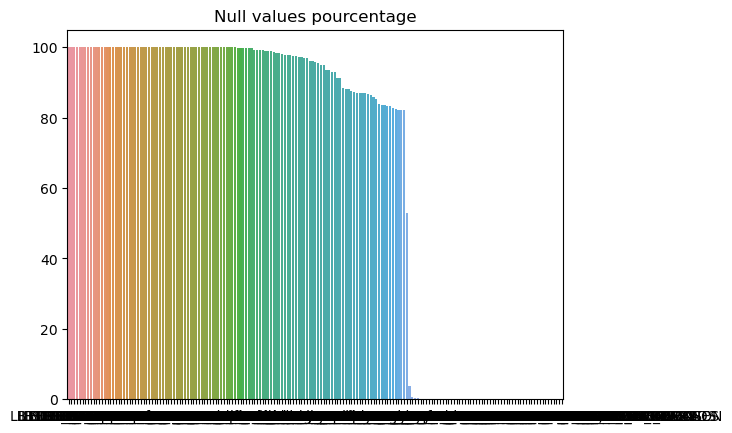

In [559]:
# Hist of NA per column
null_values = df_matrixAll_woTime.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values).set_title('Null values pourcentage')

In [560]:
# Keep columns with more than 10000 non NA values
df_matrixAll_woTime_woNA = df_matrixAll_woTime.dropna(thresh=10000, axis=1)
df_matrixAll_woTime_woNA.shape

(601915, 104)

In [561]:
# See what columns remain
df_matrixAll_woTime_woNA.columns

Index(['USUBJID', 'AGE', 'SEX', 'CONTINENT_AF', 'CONTINENT_AS', 'CONTINENT_EU',
       'CONTINENT_NA', 'CONTINENT_OC', 'CONTINENT_SA', 'DSDECOD',
       ...
       'VSTEST_CPLRFLT', 'VSTEST_DIABP', 'VSTEST_HEIGHT', 'VSTEST_HR',
       'VSTEST_MAP', 'VSTEST_OXYSAT', 'VSTEST_RESP', 'VSTEST_SYSBP',
       'VSTEST_TEMP', 'VSTEST_WEIGHT'],
      dtype='object', length=104)

### 5.2. Investigate if the data missing at random or not ?

<AxesSubplot: >

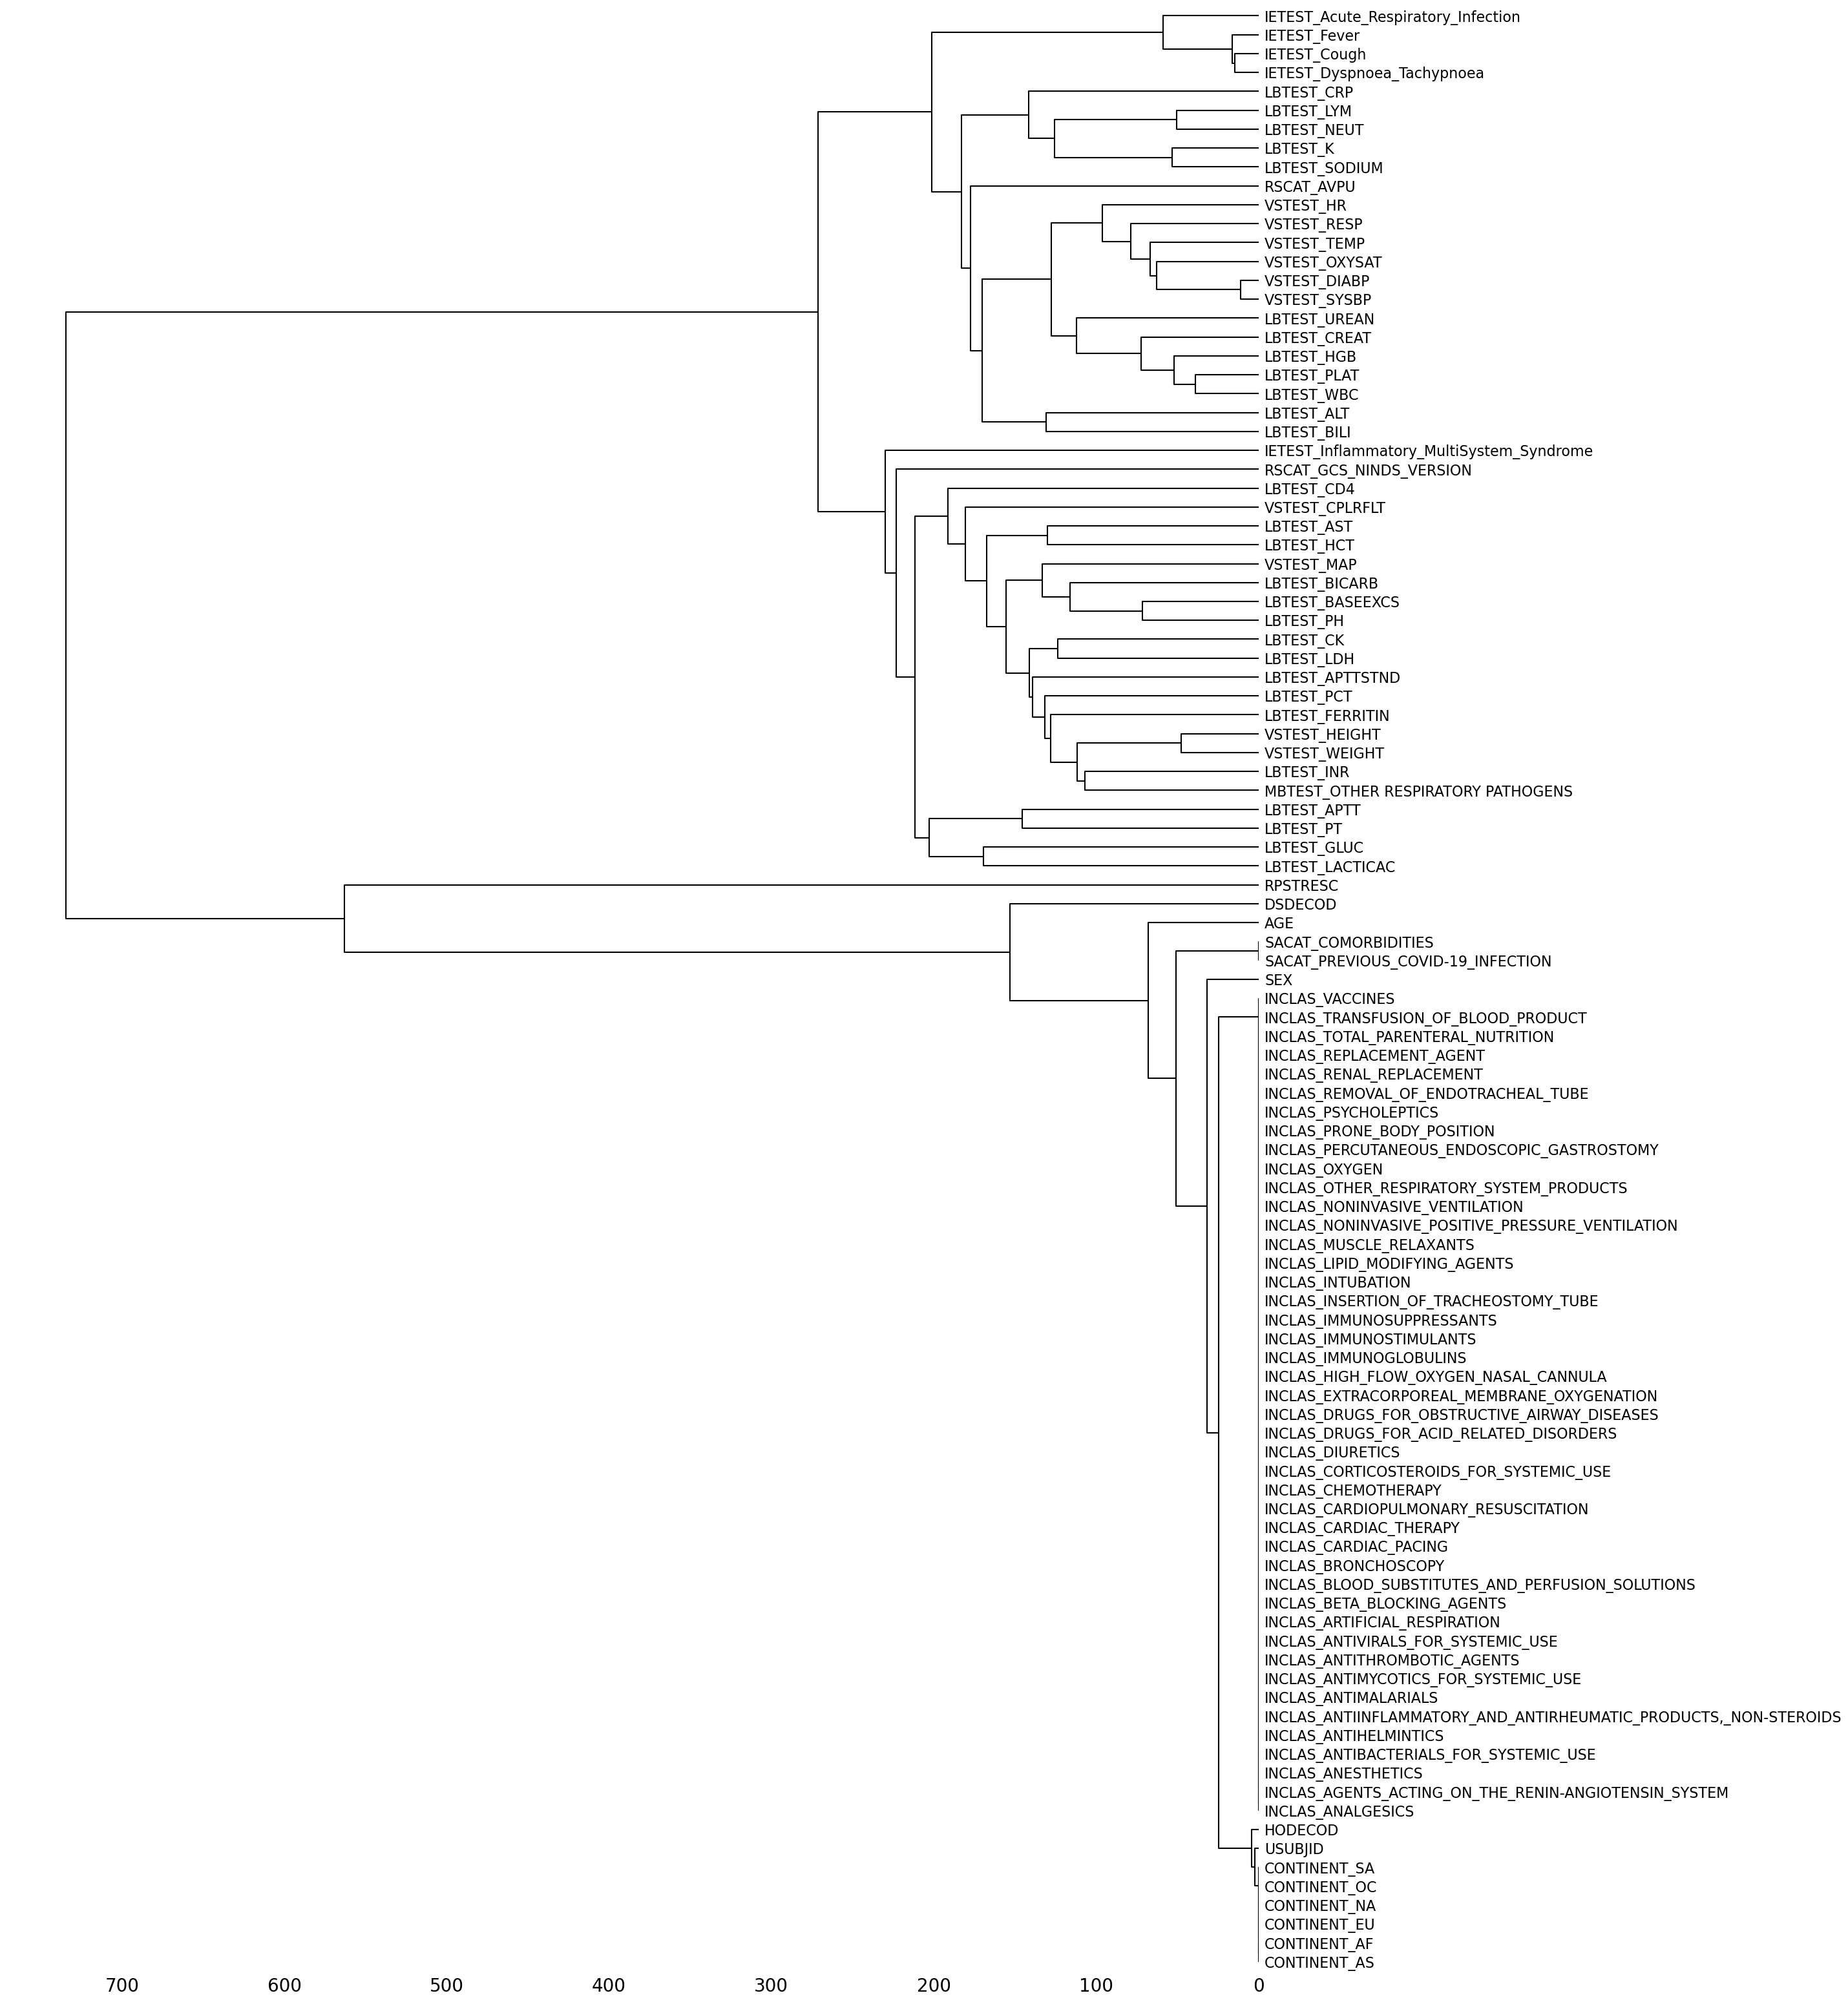

In [562]:
# Missingness Dendrogram
msno.dendrogram(df_matrixAll_woTime_woNA)

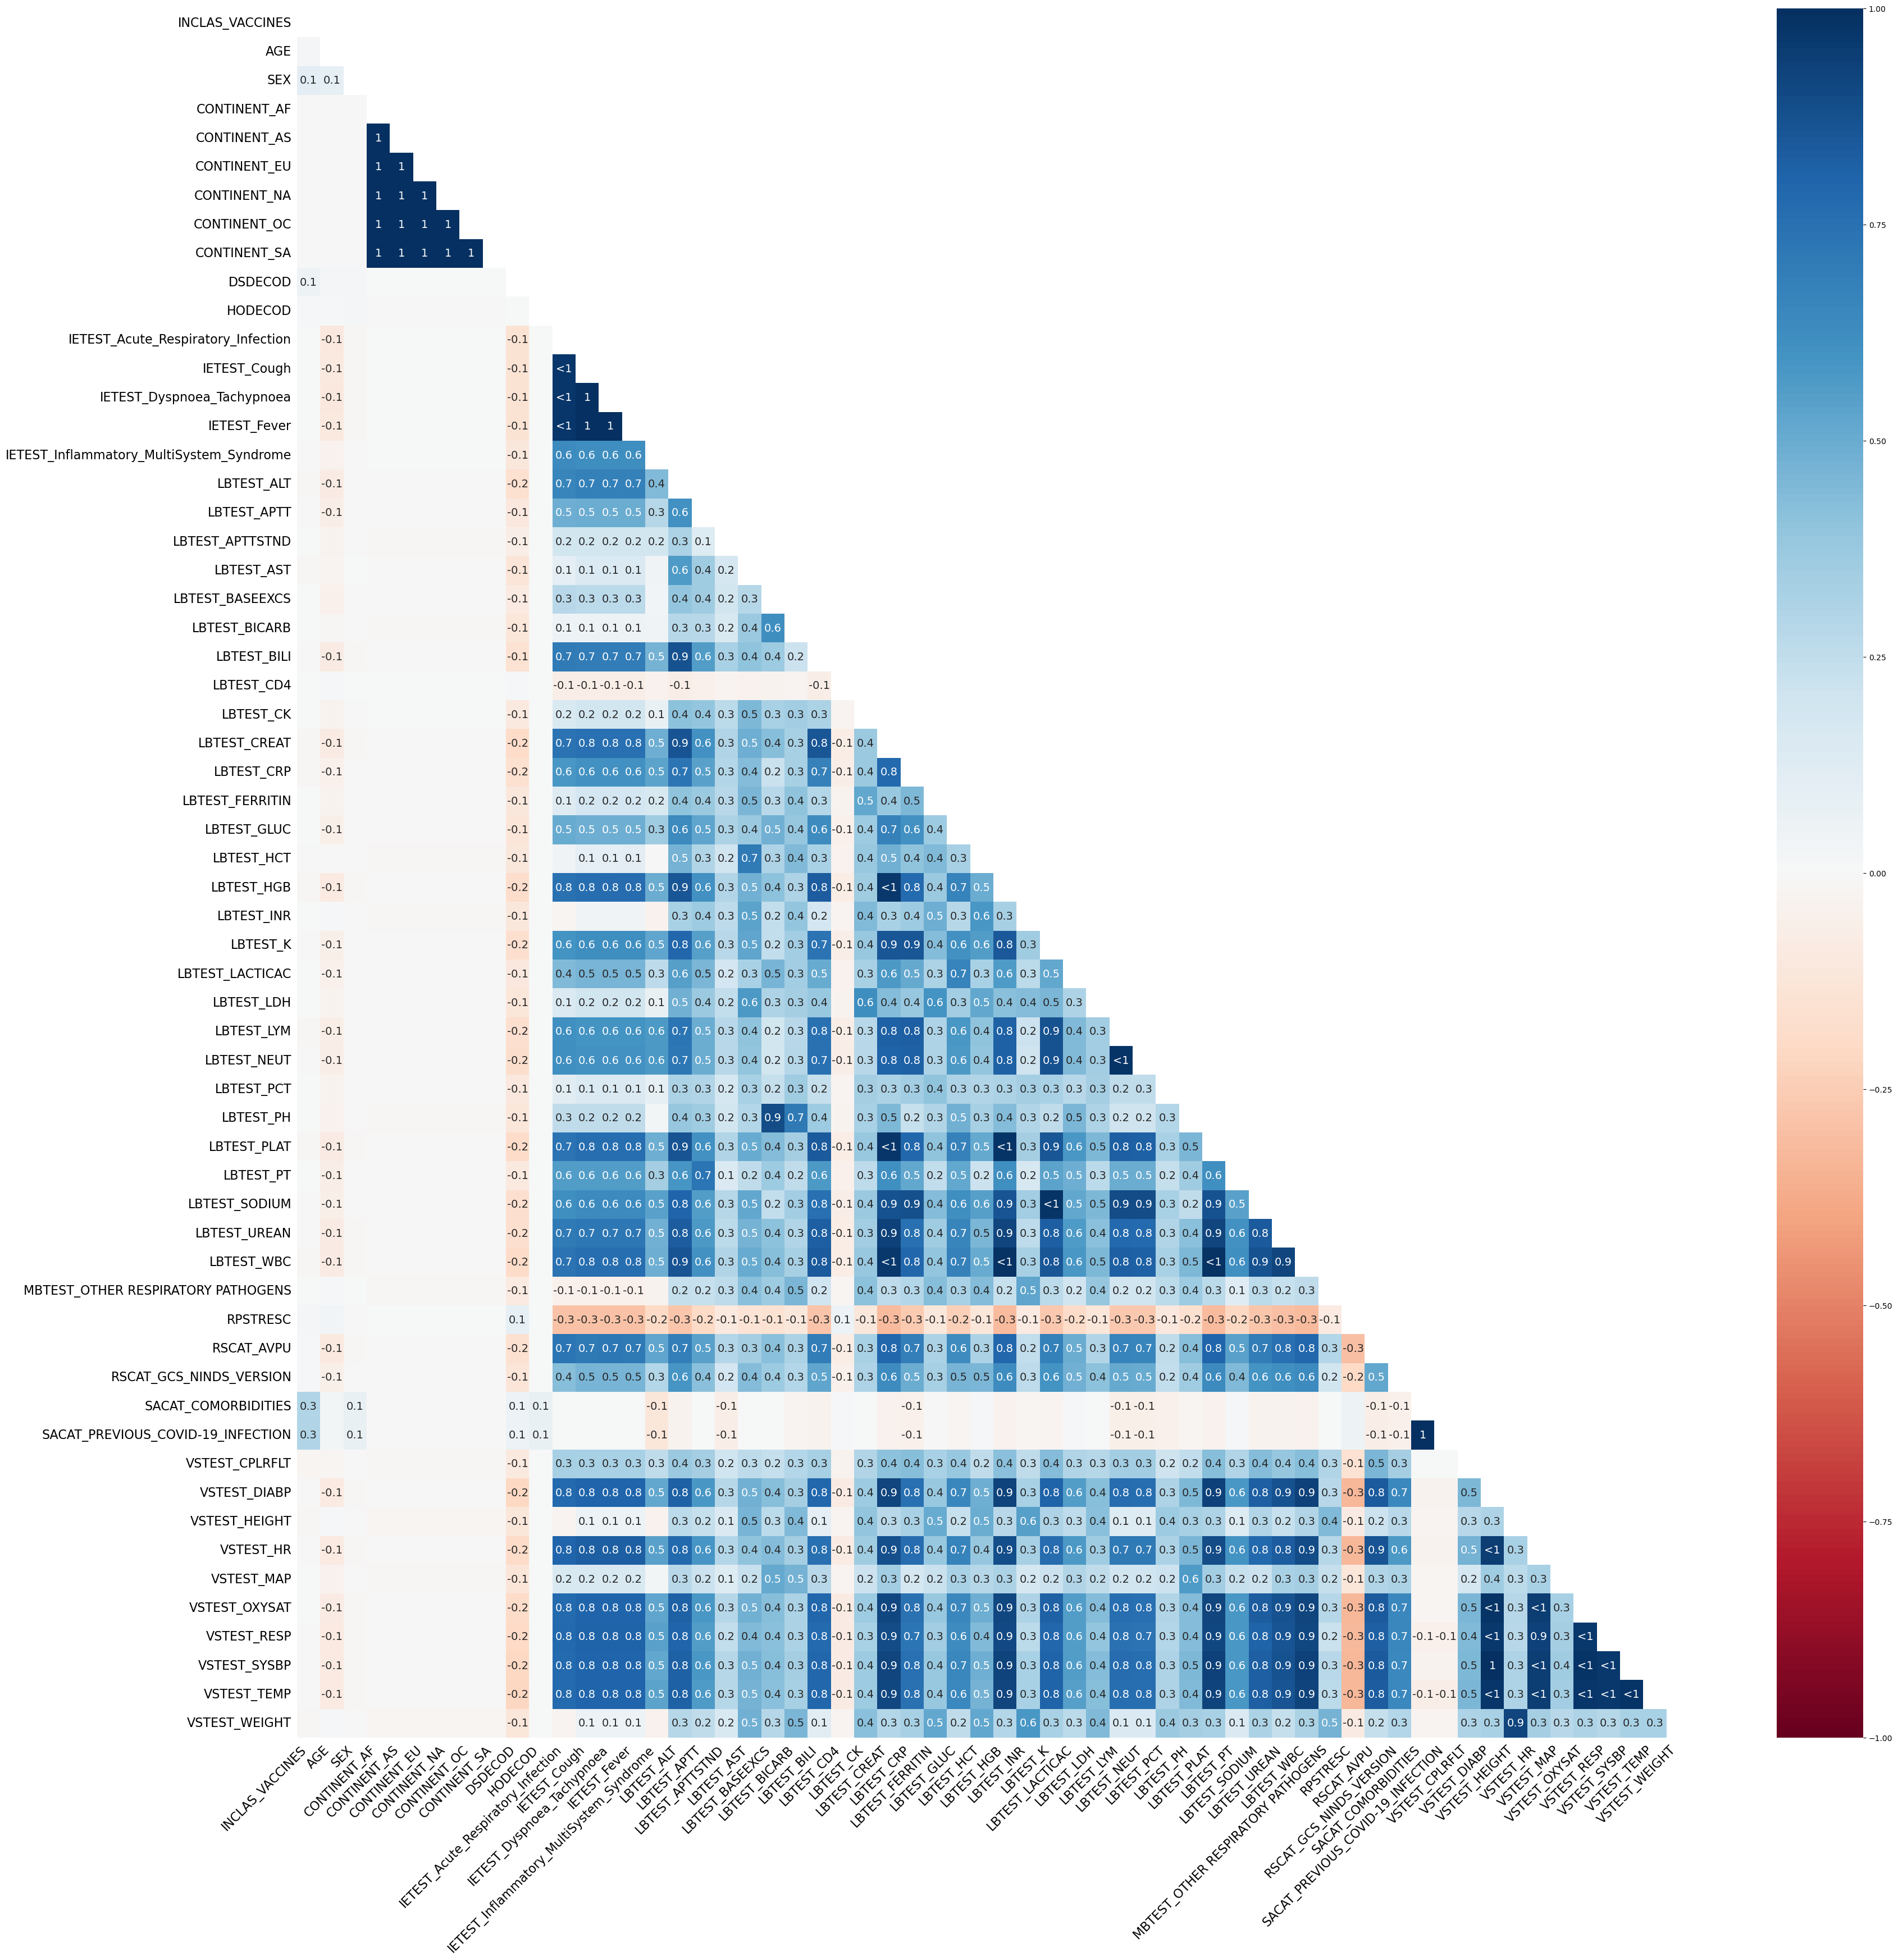

In [563]:
# Missingness Heatmap

# We will use only one INCLAS column to do the heatmap because we saw that the NA were well correlated
df_heatmap = df_matrixAll_woTime_woNA[df_matrixAll_woTime_woNA.columns.drop(list(df_matrixAll_woTime_woNA.filter(regex='INCLAS')))]
df_heatmap.insert(0,'INCLAS_VACCINES', df_matrixAll_woTime_woNA.INCLAS_VACCINES)

fig, ax = plt.subplots(1,1,figsize=(40,40))
msno.heatmap(df_heatmap, ax=ax, labels=True)
plt.savefig('./data/results/NA_heatmap.png')

C:\Users\sande\anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


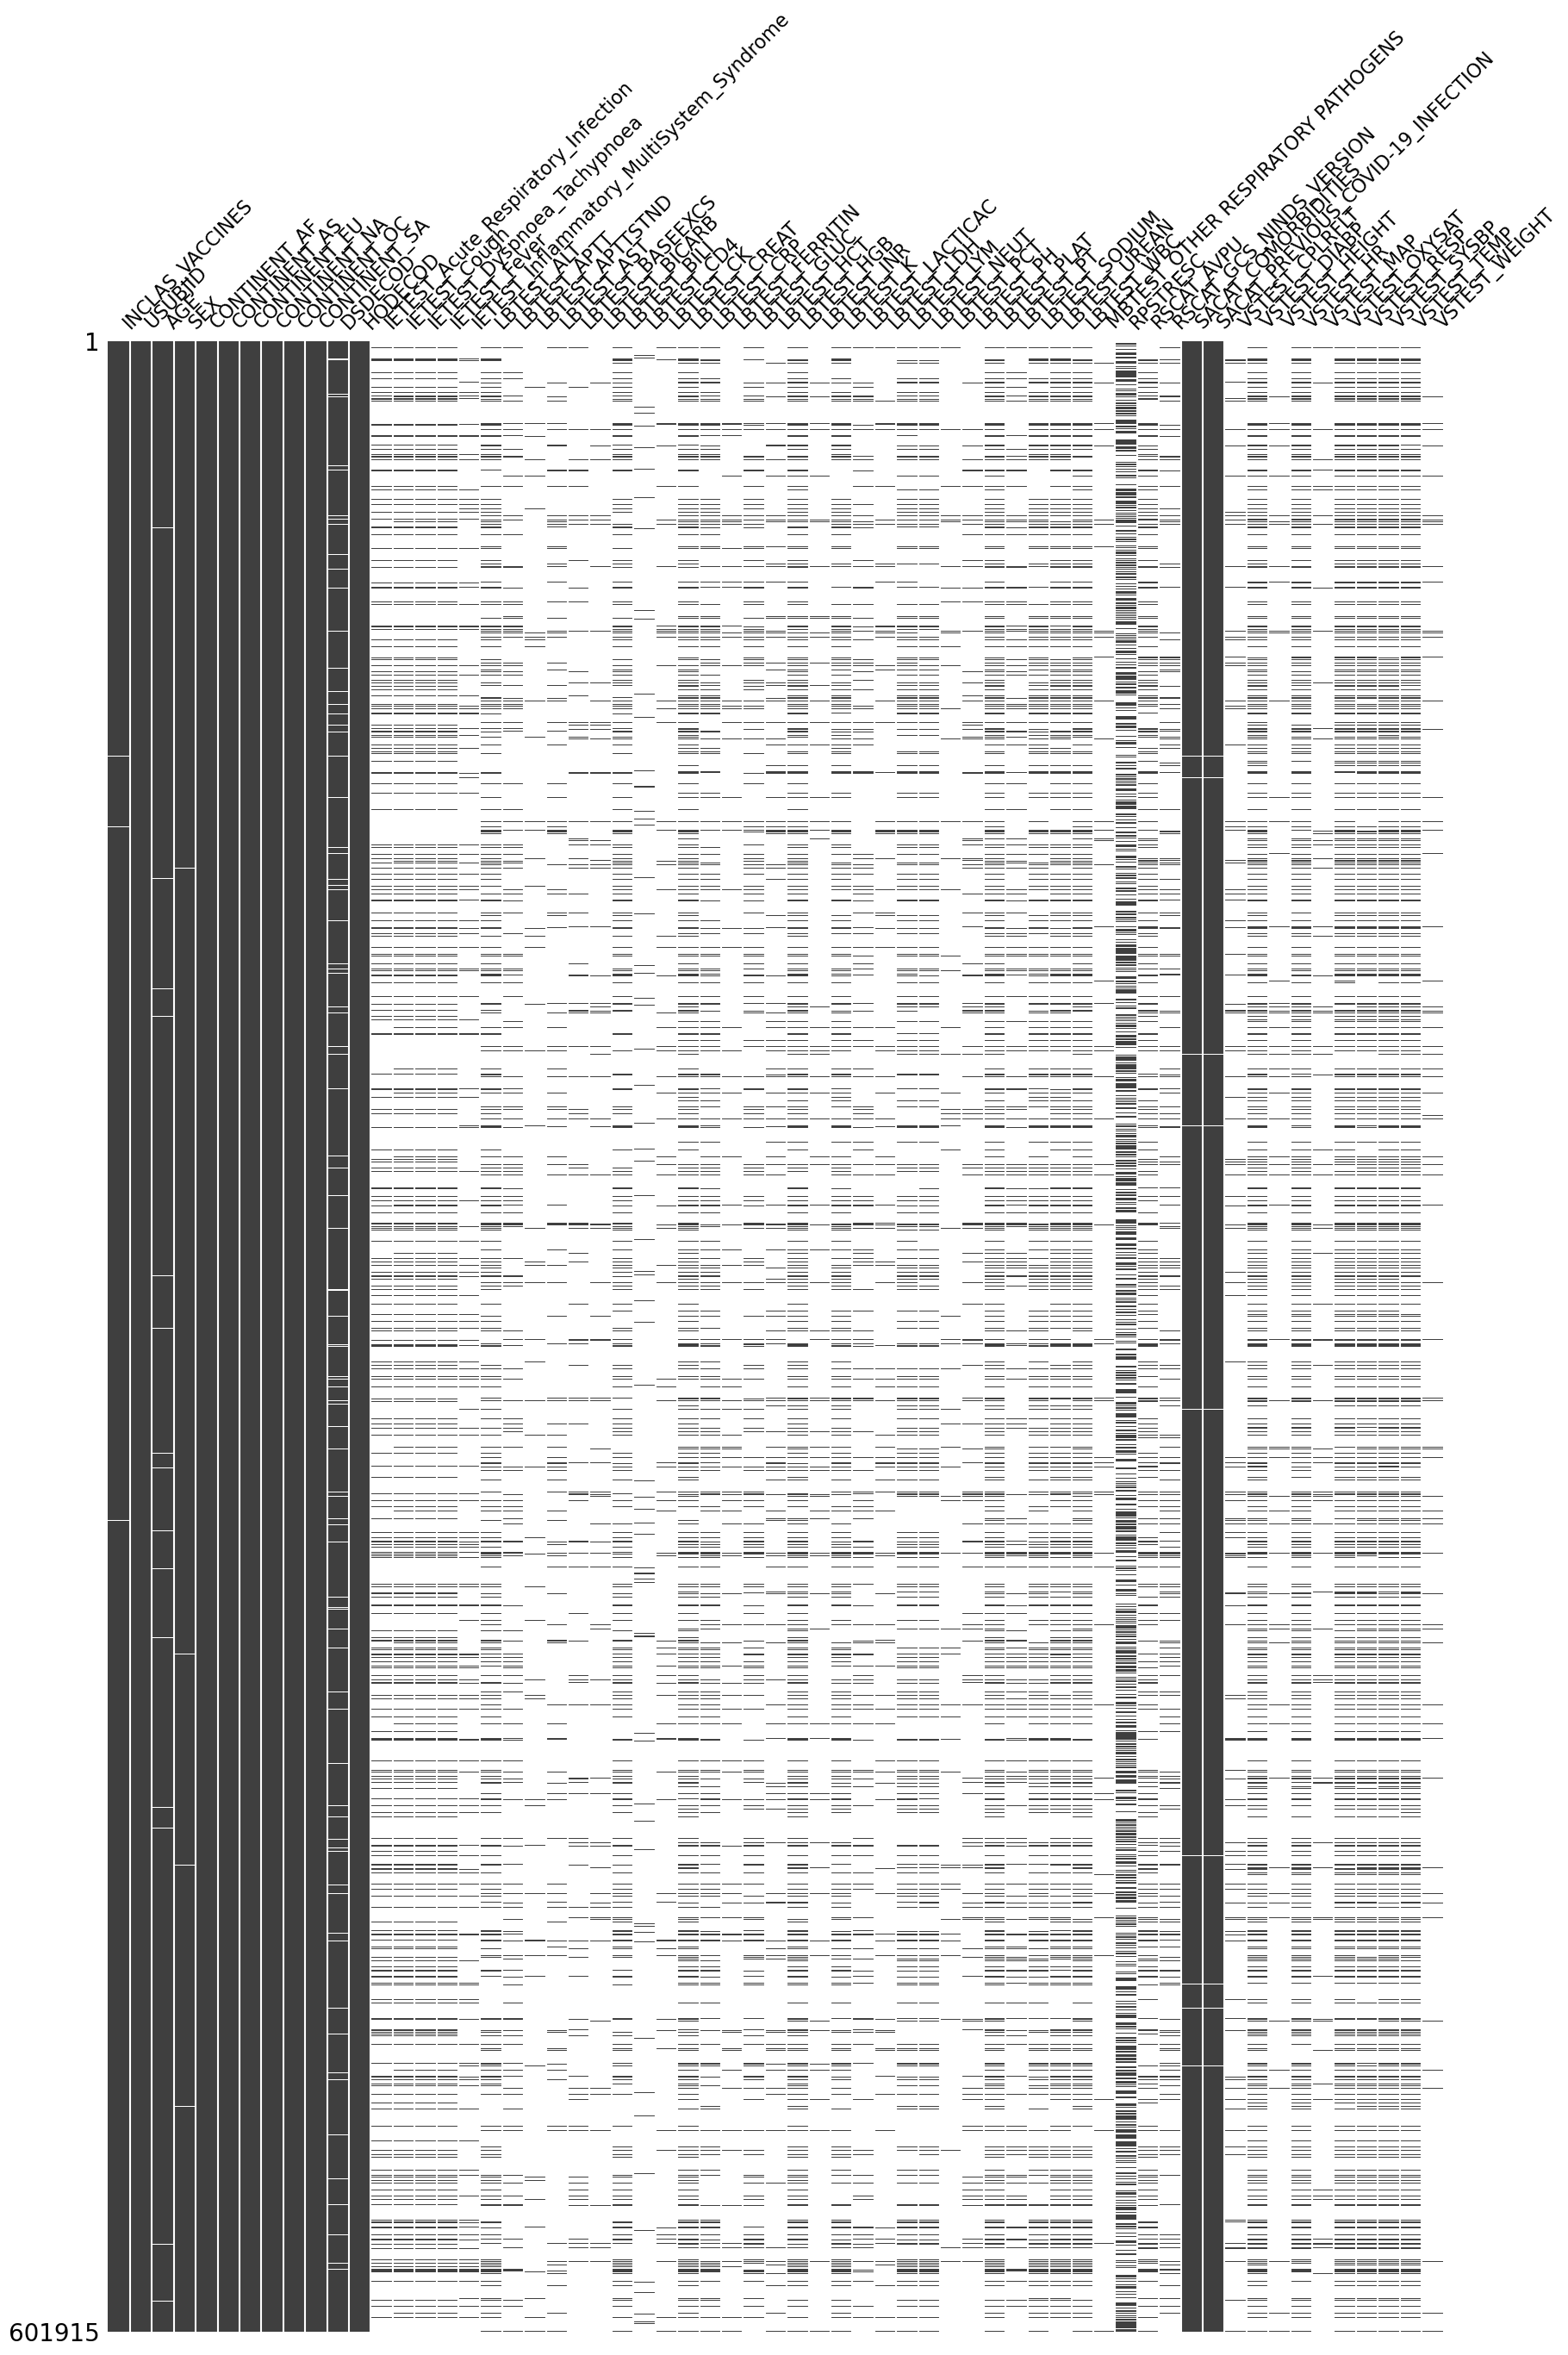

In [564]:
# Visualize NA
# We will use only one INCLAS column to do the heatmap because we saw that the NA were well correlated
fig, ax = plt.subplots(1,1,figsize=(20,30))
msno.matrix(df_heatmap, ax=ax, labels=True)
plt.savefig('./data/results/NA_matrix.png')

<AxesSubplot: >

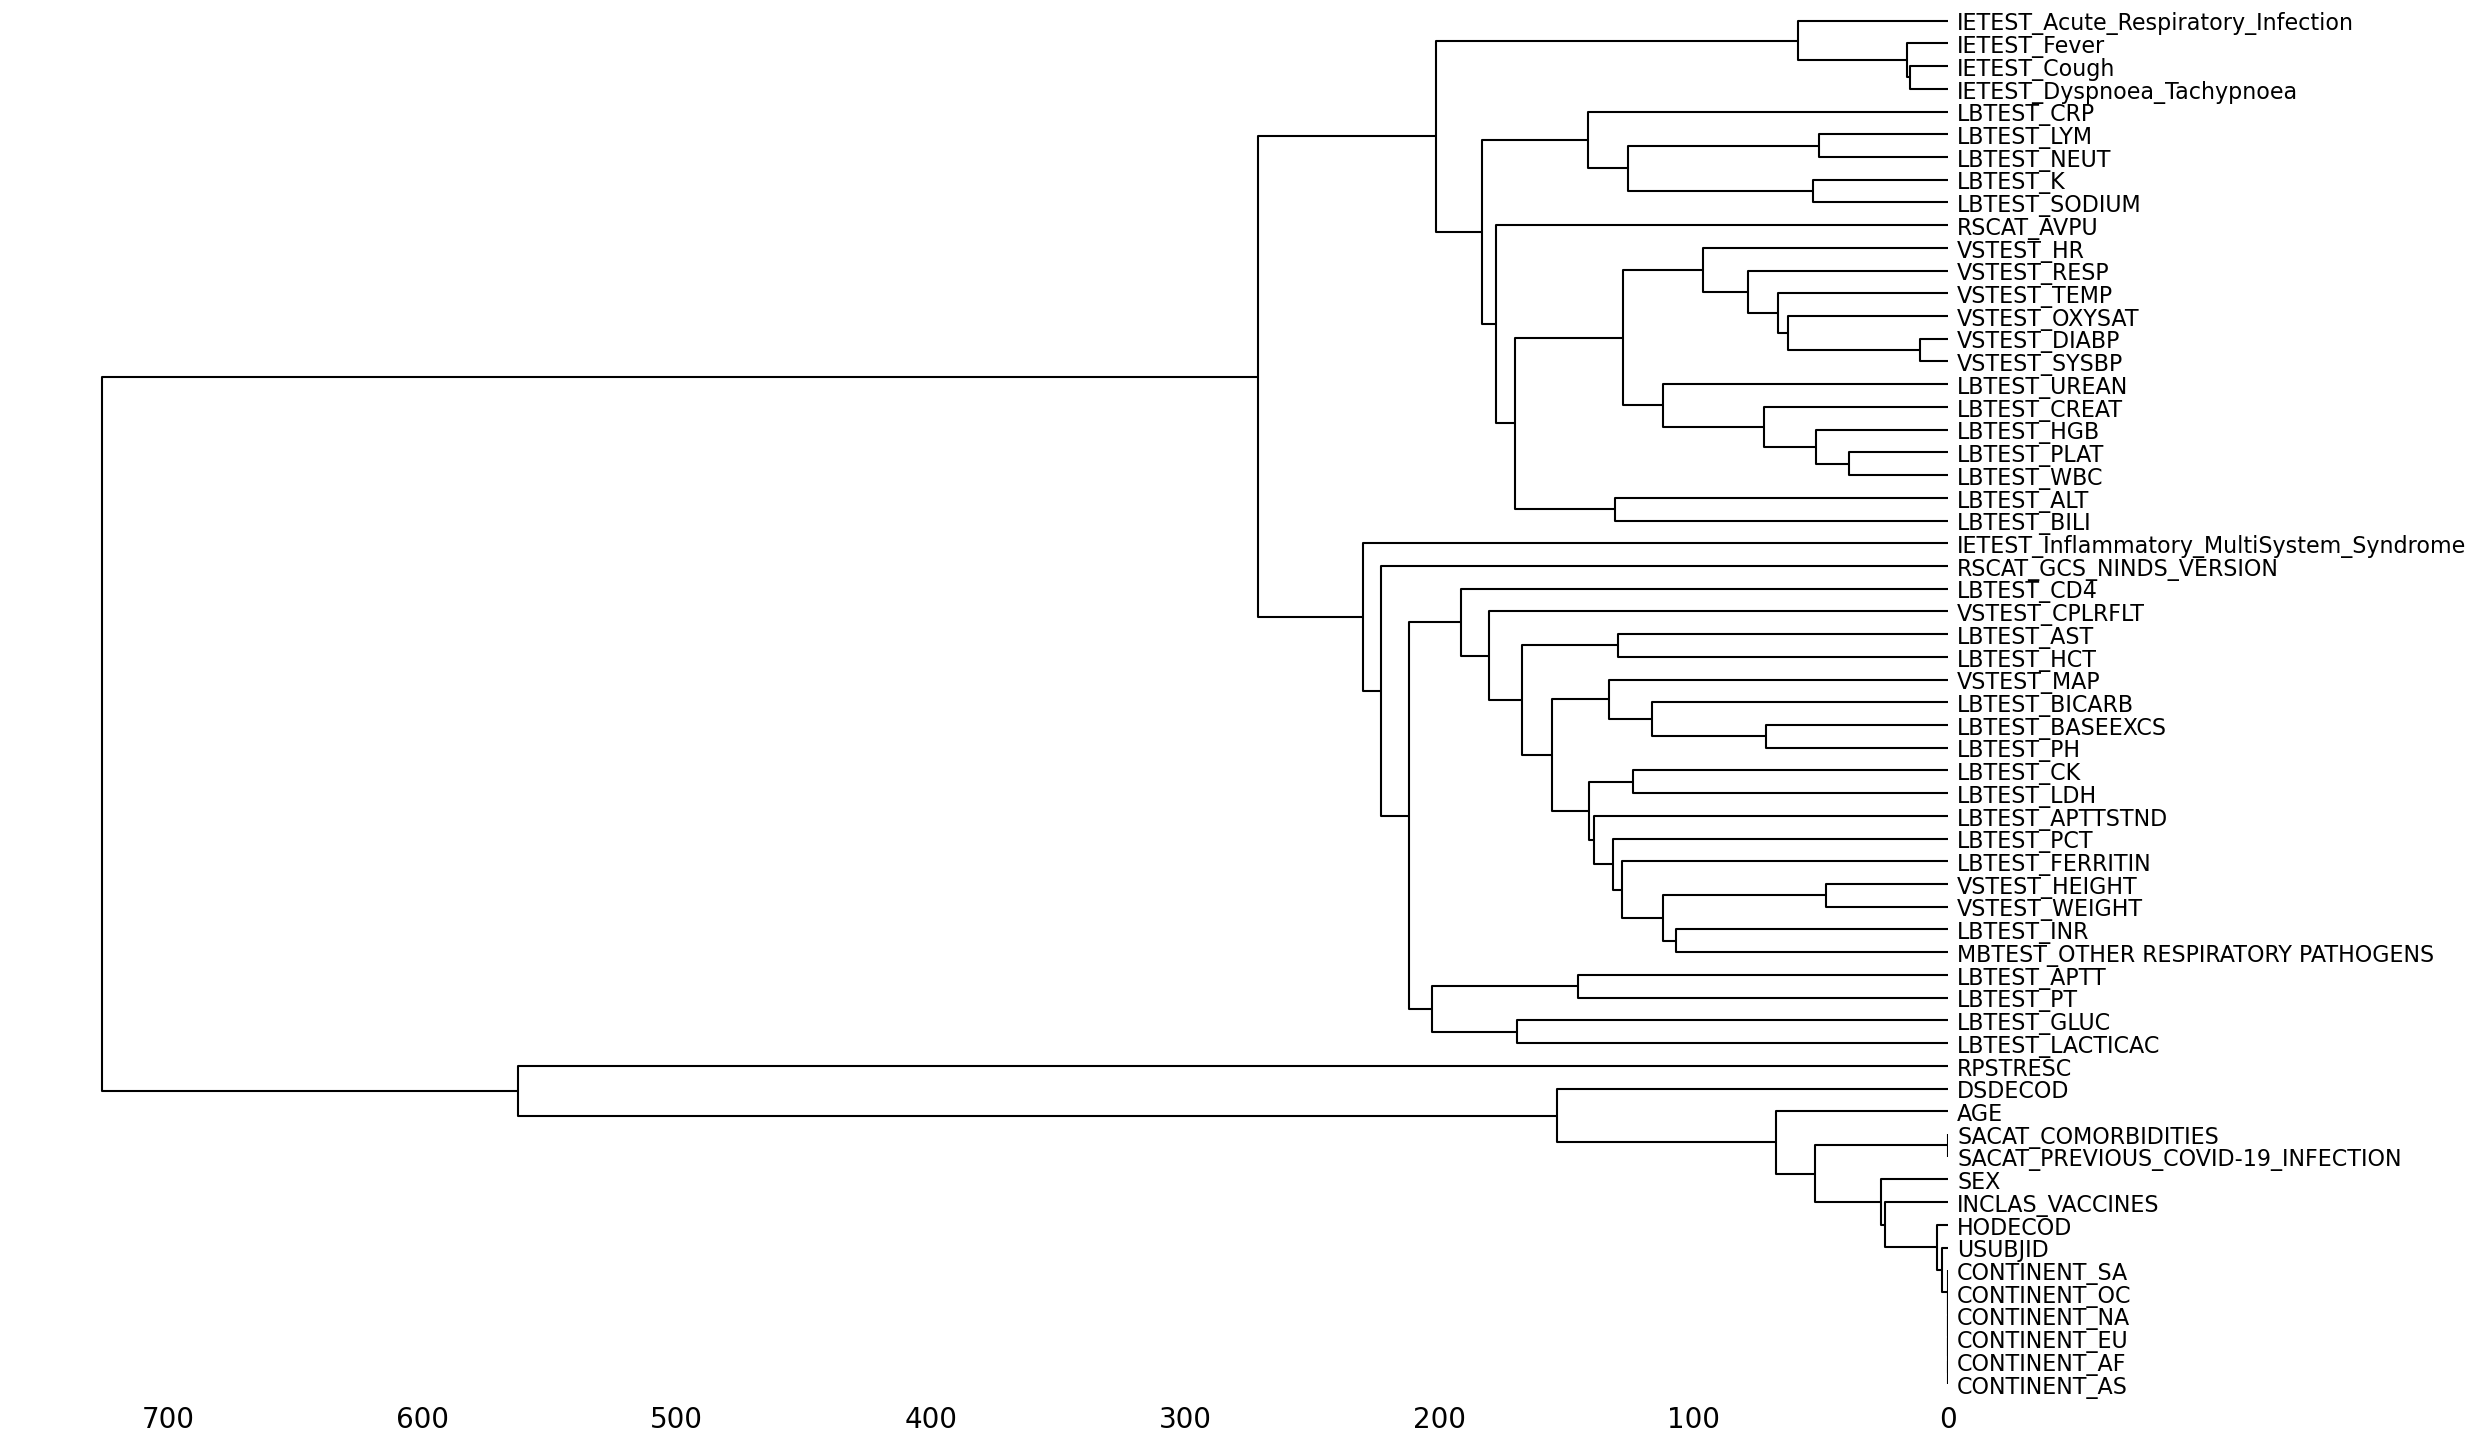

In [565]:
# Missingness Dendrogram
# We will use only one INCLAS column to do the heatmap because we saw that the NA were well correlated
msno.dendrogram(df_heatmap)

### 5.3. Conclusion

In [566]:
# Save
df_matrixAll_woTime_woNA.to_csv('./data/results/df_matrixAll_woTime_woNA.csv')

**NA are not missing at random.** Some solutions are to... : 
- Either delete columns with too many NA (but be careful not to delete rows, otherwise there is a bias) -> in order to do a regression for example. 
- Complete the columns with methods to fillNA (but introduce a bias because we do not have NA at random), 
- Use an algo for which NA is not a problem.

## 6. Correlations

In [567]:
# Open file
data_folder = './data/results/'
mylist = []
for chunk in pd.read_csv(data_folder + 'df_matrixAll_woTime_woNA.csv', sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
df = pd.concat(mylist, axis=0)
df.name = 'df'
del mylist

In [568]:
df.drop(columns=['Unnamed: 0', 'USUBJID'], inplace=True)

In [569]:
df.shape

(601915, 103)

The following code can be used to generate a Profile Report of the dataset. 
It doesn't always work (sometime generating an error saying we require 49.5Tb of memory, but when it does it generated an 
excellent )

```
# EDA on df
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("./data/results/EDA_df.html")
```

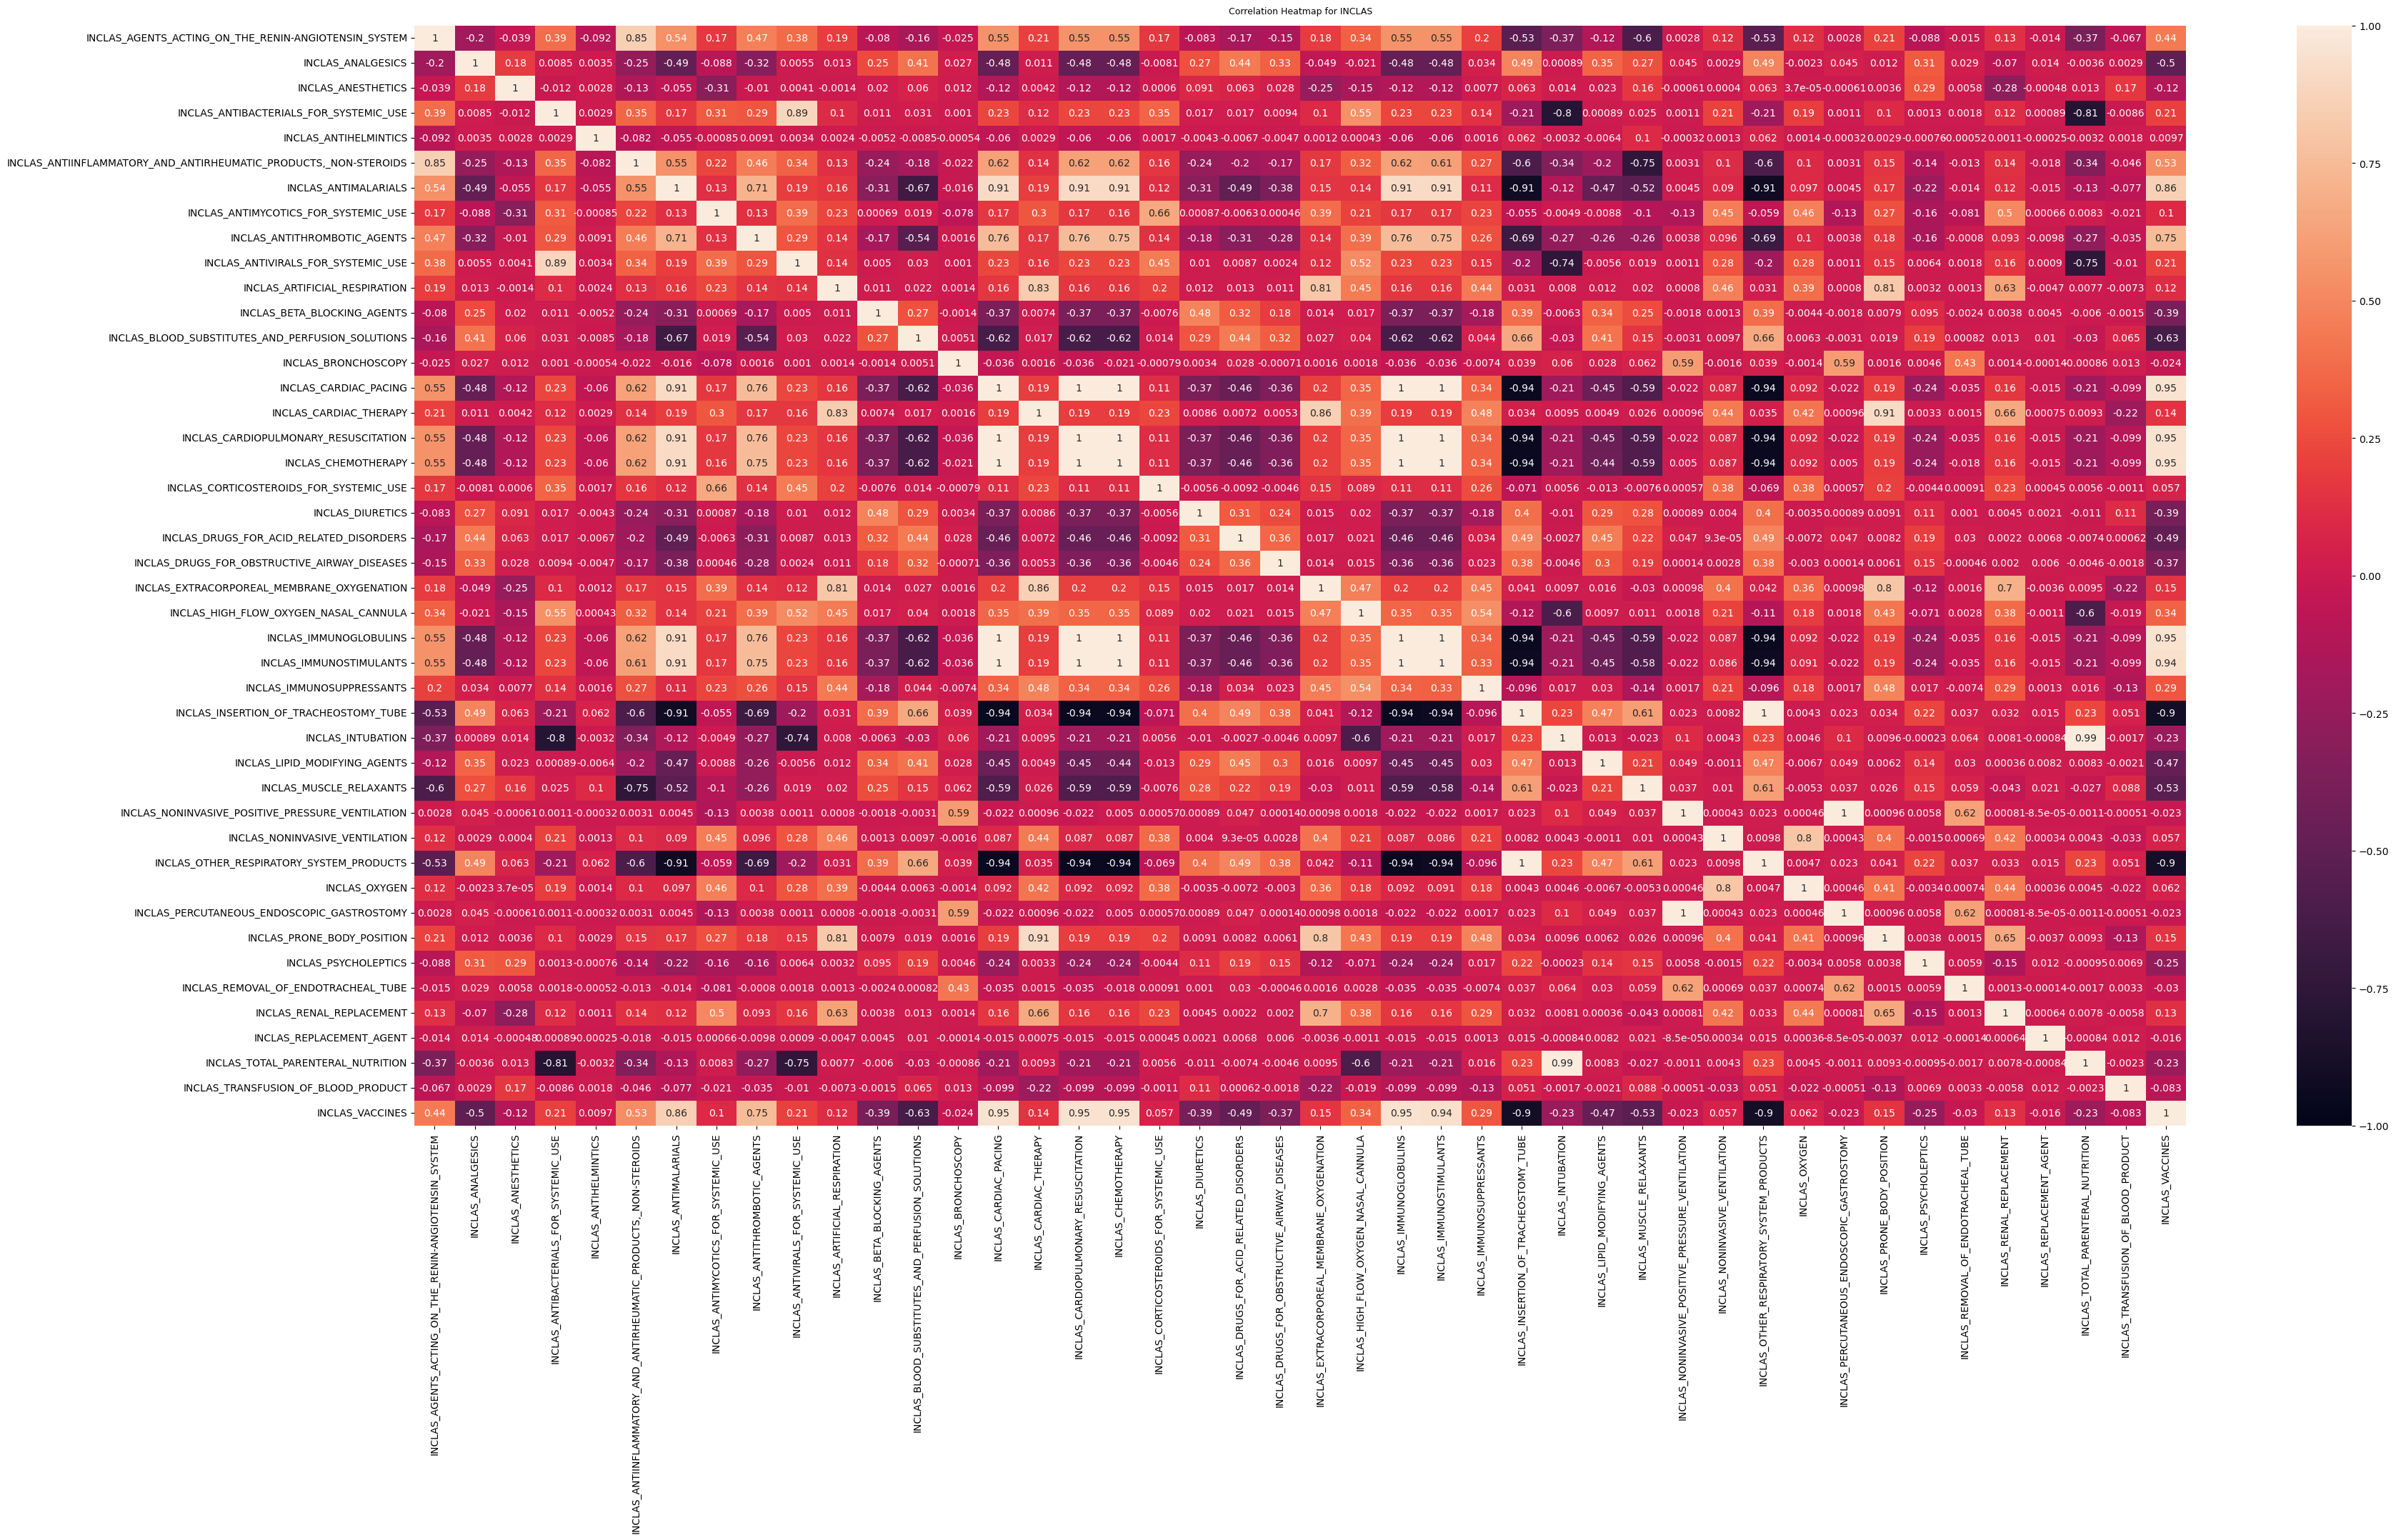

In [571]:
# Correlation heatmap for INCLAS

# We will use INCLAS column to do the heatmap
df_corrHeatmap_INCLAS = df.filter(regex='INCLAS')

plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(df_corrHeatmap_INCLAS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for INCLAS', fontdict={'fontsize':9}, pad=12)
plt.savefig('./data/results/corrHeatmap_INCLAS.png')

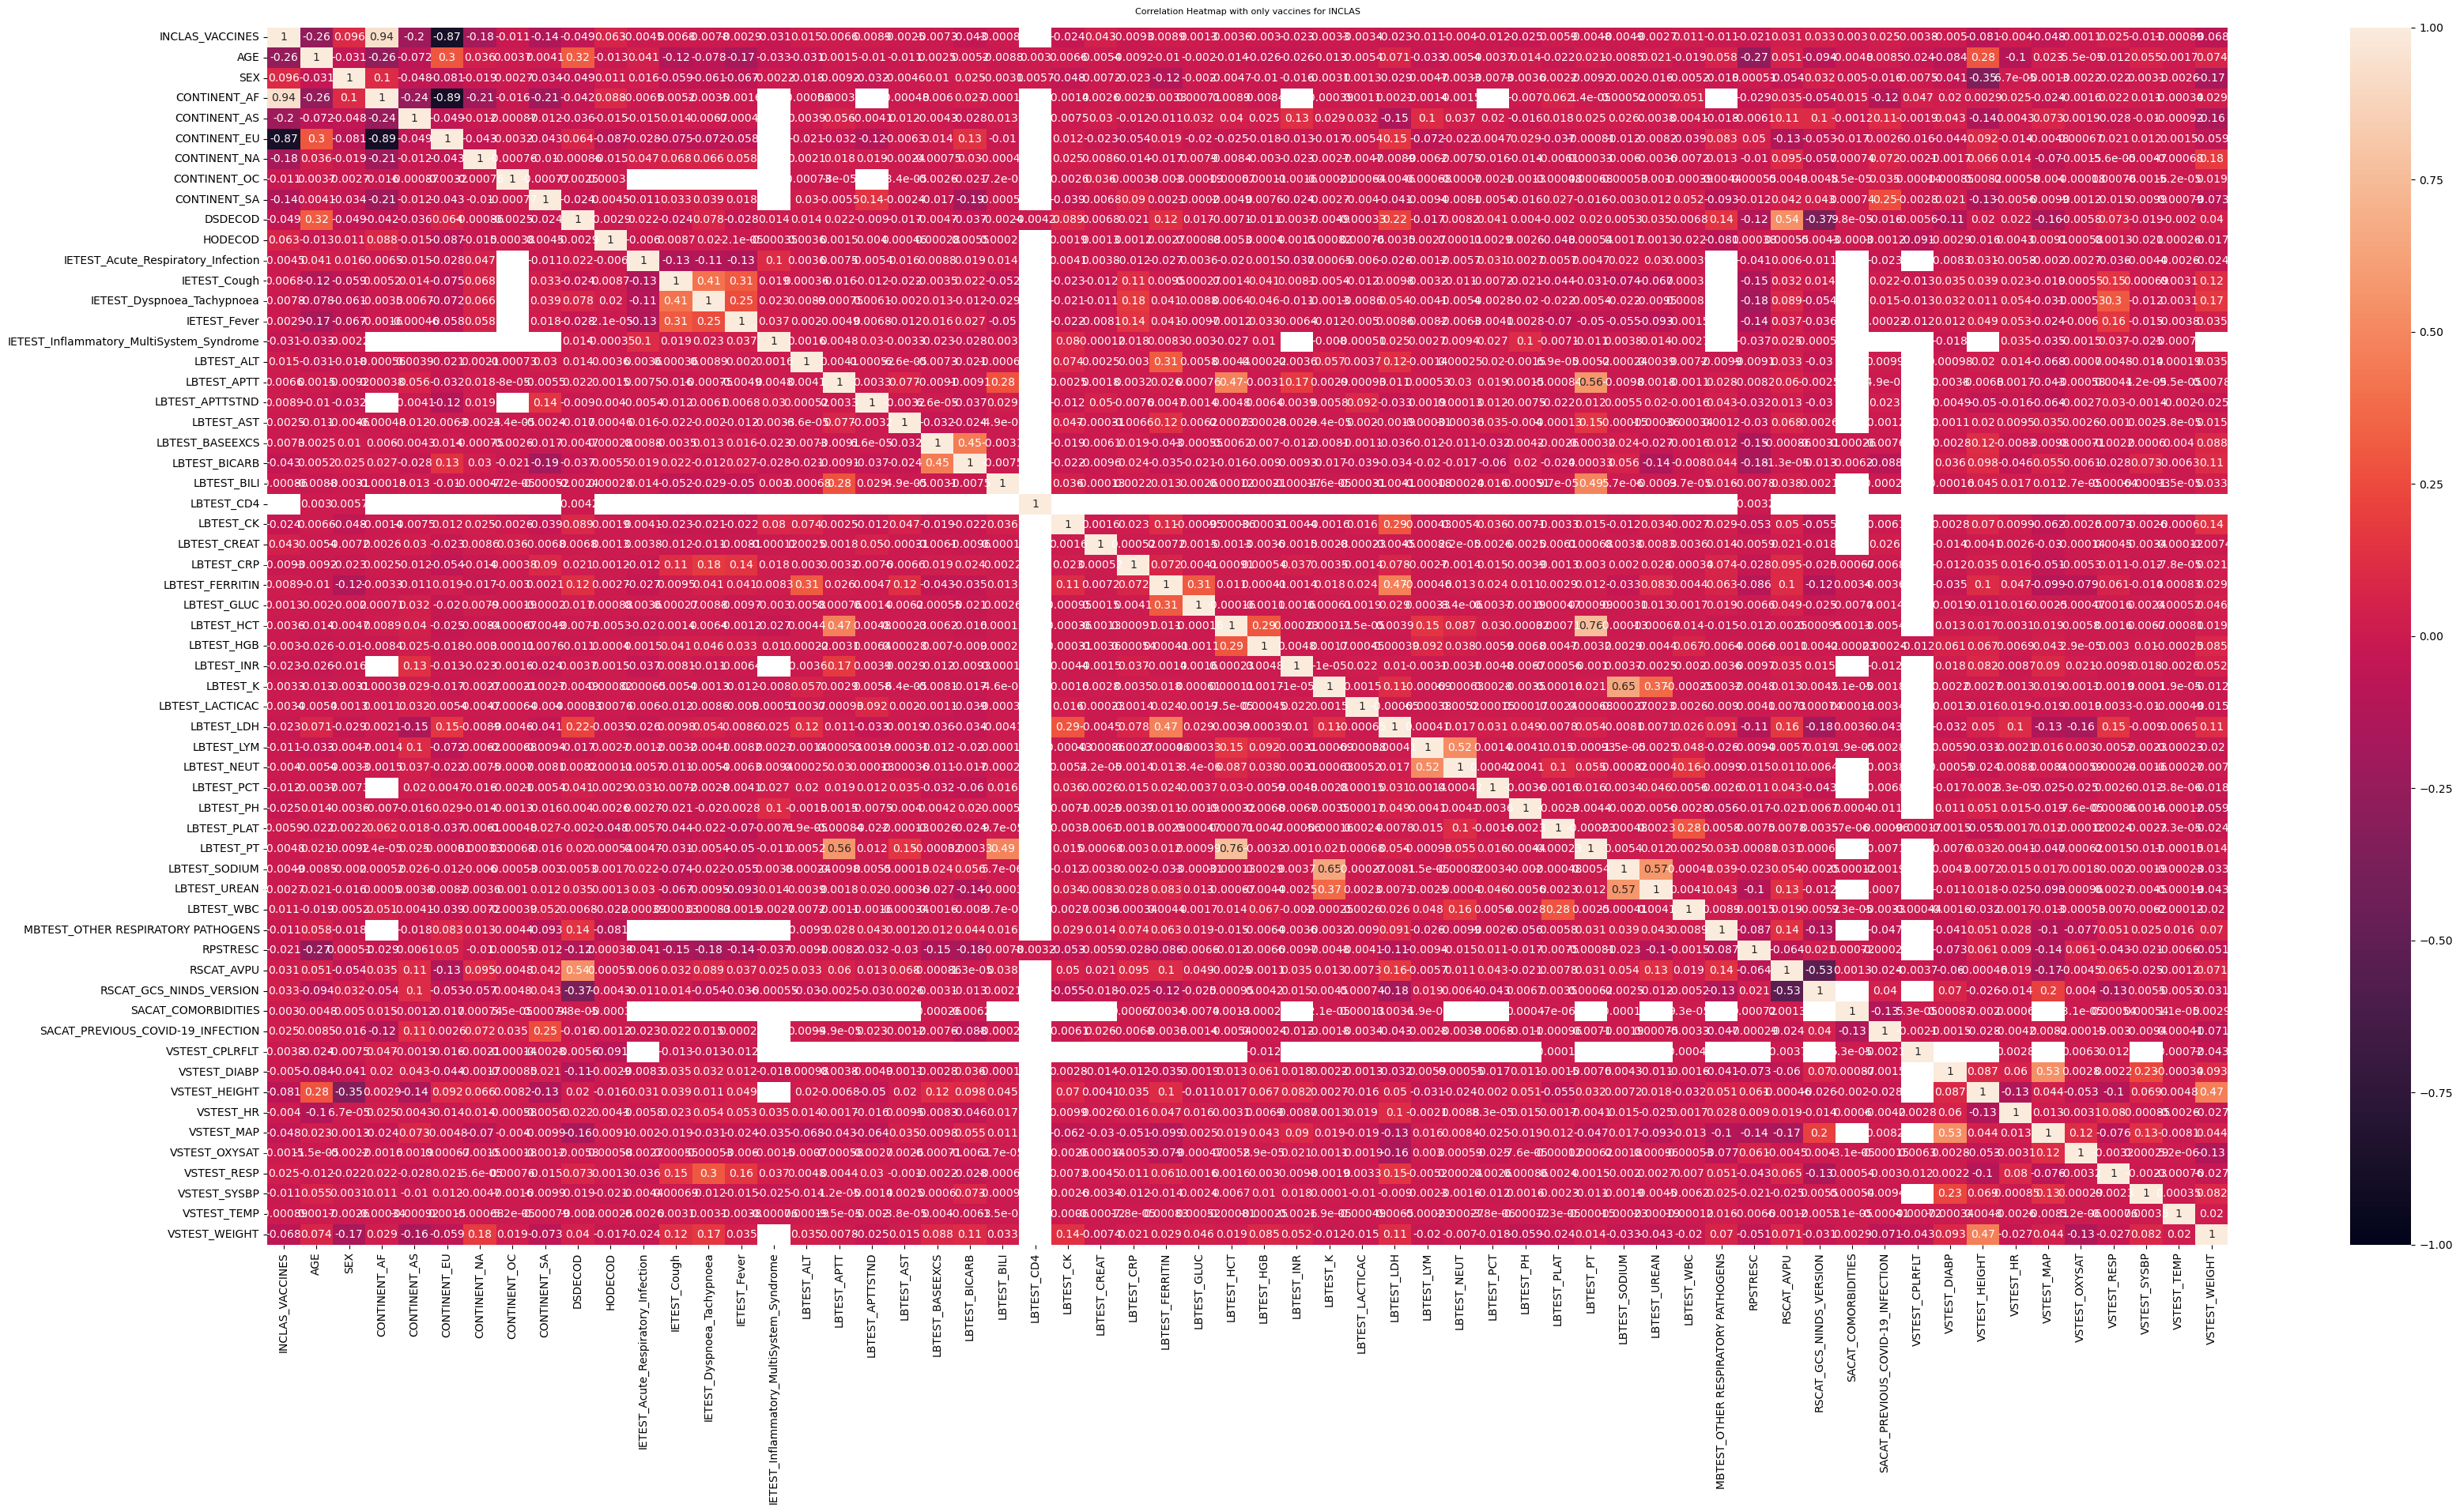

In [572]:
# Correlation heatmap with only vaccines for INCLAS

# We will use only one INCLAS column to do the heatmap
df_corrHeatmap = df[df.columns.drop(list(df.filter(regex='INCLAS')))]
df_corrHeatmap.insert(0,'INCLAS_VACCINES', df.INCLAS_VACCINES)

plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(df_corrHeatmap.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap with only vaccines for INCLAS', fontdict={'fontsize':8}, pad=12)
plt.savefig('./data/results/corrHeatmap.png')

In [573]:
# Top Absolute Correlations for INCLAS

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations for INCLAS")
print(get_top_abs_correlations(df_corrHeatmap_INCLAS, 30))

Top Absolute Correlations for INCLAS
INCLAS_NONINVASIVE_POSITIVE_PRESSURE_VENTILATION  INCLAS_PERCUTANEOUS_ENDOSCOPIC_GASTROSTOMY    1.000000
INCLAS_CARDIAC_PACING                             INCLAS_CARDIOPULMONARY_RESUSCITATION          0.999842
                                                  INCLAS_IMMUNOGLOBULINS                        0.999798
INCLAS_CARDIOPULMONARY_RESUSCITATION              INCLAS_IMMUNOGLOBULINS                        0.999650
INCLAS_CARDIAC_PACING                             INCLAS_CHEMOTHERAPY                           0.998809
INCLAS_CARDIOPULMONARY_RESUSCITATION              INCLAS_CHEMOTHERAPY                           0.998662
INCLAS_CHEMOTHERAPY                               INCLAS_IMMUNOGLOBULINS                        0.998618
INCLAS_INSERTION_OF_TRACHEOSTOMY_TUBE             INCLAS_OTHER_RESPIRATORY_SYSTEM_PRODUCTS      0.998223
INCLAS_CHEMOTHERAPY                               INCLAS_IMMUNOSTIMULANTS                       0.997615
INCLAS_CARDIAC_PAC

In [574]:
# Top Absolute Correlations with only vaccines for INCLAS
print("Top Absolute Correlations with only vaccines for INCLAS")
print(get_top_abs_correlations(df_corrHeatmap, 15))

Top Absolute Correlations with only vaccines for INCLAS
INCLAS_VACCINES  CONTINENT_AF               0.943048
CONTINENT_AF     CONTINENT_EU               0.887615
INCLAS_VACCINES  CONTINENT_EU               0.869331
LBTEST_HCT       LBTEST_PT                  0.760014
LBTEST_K         LBTEST_SODIUM              0.646000
LBTEST_SODIUM    LBTEST_UREAN               0.566955
LBTEST_APTT      LBTEST_PT                  0.562878
DSDECOD          RSCAT_AVPU                 0.535344
VSTEST_DIABP     VSTEST_MAP                 0.534537
RSCAT_AVPU       RSCAT_GCS_NINDS_VERSION    0.530758
LBTEST_LYM       LBTEST_NEUT                0.519761
LBTEST_BILI      LBTEST_PT                  0.485959
LBTEST_APTT      LBTEST_HCT                 0.474996
LBTEST_FERRITIN  LBTEST_LDH                 0.468081
VSTEST_HEIGHT    VSTEST_WEIGHT              0.467881
dtype: float64


In [575]:
# Save
df.to_csv('./data/results/df_final_I-DataSelection.csv')